## Part 1: Motivation

Copenhagen is known as one of the biggest bike cities in the world. People mainly rely on their bikes and public transport for their daily commute. We want to look into which weather conditions affect the daily commute routine of the people of Copenhagen. Do people tend to park their bikes and use their cars in heavy weather conditions or does the traffic stay consistent? The datasets used to come to a conclusion and visualize the actual commute behavior of the residents of Copenhagen are the following:

- Bike traffic in Copenhagen from 2012-2014, obtained from https://www.opendata.dk/city-of-copenhagen/trafiktal
- Car traffic in Copenhagen from 2012-2014, obtained from https://www.opendata.dk/city-of-copenhagen/kobenhavns-kommunes-servicemal-for-trafikledelse-2014-2018
- Weather data for Copenhagen from 2012-2014, obtained from https://www.visualcrossing.com/weather/weather-data-services

The main reason for this dataset choice was simply due to the common interest of all group members being students who all rely on bikes as a primary commute. Copenhagen is listed as the 5th most sustainable city in the world, the main contributing factor is that only 29% of households own a car, and bikes are commonly used transportation tools[[1]](https://sustainabilitymag.com/top10/top-10-most-sustainable-cities-world). Our goal is to determine how weather affects temporal traffic patterns and just how committed Danes are to their cycling, is there room for improvements and making Copenhagen even greener? Finally, we want to predict the bike traffic based on weather conditions and find out which features are the most influential in the prediction.

Our main emphasis is to give the end-user a good overview of our data, visualizing temporal traffic patterns and showing how they are affected by different weather conditions. Finally, we will lay down a null hypothesis and use our features to predict the number of bikes based on location, time, and weather. The goal for the end user's experience is to interweave our visualizations and theoretical findings into a magazine-style article hosted on a website. The goal of the website is to give the end-user an accessible website covering the main aspects of our findings with good relation to visualizations.

For a further overview of the project, and objectives have a look at our introductory video below.

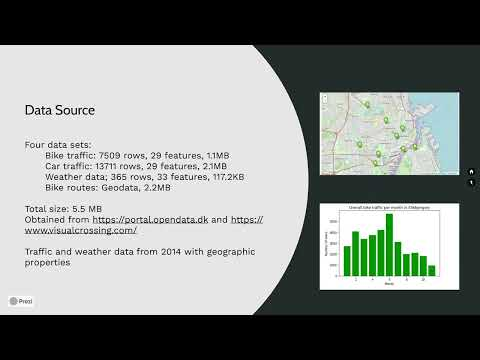

In [62]:
from IPython.display import YouTubeVideo
YouTubeVideo("6djzwgxQpeo", width = 800, height = 450)

## Part 2: Formatting Notice 

The assignment should be accessible and easily read. Each section is split into subsections in a logical order to make the navigation through the code section understandable and flow with the result comments. Each subsection states a summary of the main aspects of the section and the tools used to implement the logic. 

Code is commented where needed and to lead you through the coding process we have placed code process markdown cells to lead you through. Plots are described using Plot Description headers and if there is anything remarkable to comment on it is marked with the Result Comments header below the plots.

**Important:** If you are not seeing the interactive plots, try trusting the notebook.

We hope that the markdowns are clear and that the project is accessible to you.

## Part 3:  Data Cleaning and Basic Statistics

As stated in the motivation section our data consists of three datasets:

**Copenhagen bike traffic data from 2014** [Source](https://www.opendata.dk/city-of-copenhagen/trafiktal)

*Data Size*: The bike traffic data is obtained from the Copenhagen municipality open data source and contains bike counts at nine measurement locations from 2012-2014, each year is obtained separately and then concatenated. The dataset consists of 35 features and 27955 rows, the data size is 4.034KB.

*Data Cleaning:*

**Copenhagen car traffic data from 2014** [Source](https://www.opendata.dk/city-of-copenhagen/kobenhavns-kommunes-servicemal-for-trafikledelse-2014-2018)

The car traffic data is obtained from the Copenhagen municipality open data source and contains bike counts at 15 measurement locations from 2012-2014, each year is obtained separately and then concatenated.  The dataset consists of 35 features and 51466 rows, the data size is 7.494KB.

*Data Cleaning:*

**Copenhagen weather data from 2014** [Source](https://www.visualcrossing.com/weather/weather-data-services)

The weather data was collected via the Visual Crossing API. The query was built using the query builder provided on the website. The response was selected to be in a .csv format so that it could be used straight away with the pandas.read_csv() method. The data consists of 42 features describing the weather in close detail and 365 rows for each year, one for each day in Copenhagen from 2012-2014. The data size is 362KB.

*Data Cleaning:* Data cleaning decisions are discussed for each data set in the following sections:

* 3.2.2 Preprocessing of the Car Traffic Dataset
* 3.2.3 Preprocessing of the Bicycle Traffic Dataset
* 3.2.4 Preprocessing of the Weather Dataset


### 3.1: Warnings and Package Imports

The following piece of code is written to minimize warning outputs in the notebook since all warnings raised before this function implementation have been checked off and not are not affecting the results. This is done to increase the comfort for the end user.

In [63]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [64]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import datasets
import utm 
import calmap
import calendar

#data preprocess
from pandas.tseries.offsets import *
from datetime import date
from bdateutil import isbday
import holidays
from datetime import datetime

#Map
import folium
from scipy.stats import ttest_ind

from bokeh.layouts import gridplot
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool, Legend
from bokeh.io import push_notebook, show, output_notebook, curdoc,output_file
from bokeh.layouts import row, layout
from bokeh.models.widgets import Tabs, Panel
from bokeh.plotting import figure, output_file, save

#youtube video and HTML exports
from IPython.display import IFrame
from IPython.core.display import display, HTML

#ML model and tree viz
import shap
from dtreeviz.trees import *
from sklearn import metrics

### 3.2 Data Preprocessing

The following section covers the data gathering and preprocessing of the different data sets.


#### 3.2.1 Data Gathering

The following sub section will cover the data gathering process for this project.

***Summary***: The first step is gathering the obtained data using pandas CSV read functionality.

***Tools***: 

1. ``csv_read()``: used to import the CSV data used for this project.
2. ``pd.concat()``: used to concatinate the dataframes obtained from the different years.

**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/1:** All data is gathered using the ``read_csv()`` functionality. Once all data has been gathered to a dataframe for each year the same kind of data can be concatinated to a single dataframe so we end up with one dataframe for each; bicycles, cars and weather.

In [65]:
bicycle_data_14 = pd.read_csv('cykeltaellinger-2014.csv', sep=';', skiprows=10)
bicycle_data_13 = pd.read_csv('cykeltaellinger-2013.csv', sep=';', skiprows=10)
bicycle_data_12 = pd.read_csv('cykeltaellinger-2012.csv', sep=';', skiprows=10)

car_data_14 =  pd.read_csv('faste-trafiktaellinger-2014.csv', sep=';', skiprows=10)
car_data_13 =  pd.read_csv('faste-trafiktaellinger-2013.csv', sep=';', skiprows=10)
car_data_12 =  pd.read_csv('faste-trafiktaellinger-2012.csv', sep=';', skiprows=10)


weather_data_14 = pd.read_csv('weather_2014.csv')
weather_data_13 = pd.read_csv('weather_2013.csv')
weather_data_12 = pd.read_csv('weather_2012.csv')

bicycle_data = pd.concat([bicycle_data_14, bicycle_data_13, bicycle_data_12], ignore_index=True)
car_data = pd.concat([car_data_14, car_data_13, car_data_12], ignore_index=True)
weather_data = pd.concat([weather_data_14, weather_data_13, weather_data_12], ignore_index=True)

#### 3.2.2 Preprocessig of the Car Traffic Dataset

The following sub section will cover the data cleaning choices made for the Car traffic dataset.


***Summary***: The car traffic dataset required some preprocessig due to unsufficient formatting of the data and exporatation from Excel format to CSV format. The following steps were taken in order to optimize the data format for the data analysis step:

1. Altering the geographical properties of the dataset from MTC coordinate to GPS using Pyhon's UTM package indicating the zone number of Copenhagen and giving the Northern position of the city.

2. Drop un-needed columns.

3. Altering the type of the date column to datetime type.

4. Fill DataFrame NaN values with 0

5. Clean up tousand seporators in counting values correctly and cast back to float type, using the deafault functionality of Pandas impacted the Dato column format so it couldn't be used.

6. Create supporting columns total(summing up all cars during the date) along with indexes of year, month and date.

7. Dropping locations that aren't active for all years.

***Tools***:

1. ``pd.rename()``: For renaming columns
2. ``utm.to_latlon()``: Altering MTC coordinates to GPS coordinates
3. ``pd.drop()``: For dropping certain parts of the dataframe
4. ``pd.to_datetime()``: Casting columns to datetime type
5. ``pd.fillna()``: Filling NaN values with a value given by the user
6. ``pd.DateTimeIndex()``: Getting certain aspect from a datetime type column value; date, month or year in our case.

**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*


**Code Process 1/3:** Data cleaning steps 1-6

In [66]:
# Preprocessing of car dataset
# Renaming location coordinate columns from pandas name giving
car_data = car_data[car_data['Vej-Id'].str.contains("T")]
car_data = car_data.rename(columns={'(UTM32)': 'UTM Easting', '(UTM32).1': 'UTM Northing'})

# Convert UTM cordinates to lat -and longitude
car_data['lat']= utm.to_latlon(car_data['UTM Easting'], car_data['UTM Northing'], northern=True, zone_number=32)[0]
car_data['lon']= utm.to_latlon(car_data['UTM Easting'], car_data['UTM Northing'], northern=True, zone_number=32)[1]

# Drop unnecessary columns
car_data = car_data.drop(columns=['Spor', 'Unnamed: 30', 'Unnamed: 31', 
                        'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
                        'UTM Easting', 'UTM Northing'])

                        

# To mach weatherdata
car_data['Dato'] = pd.to_datetime(car_data['Dato'], dayfirst=True).dt.date

# NaN's can be filled with 0
car_data = car_data.fillna(0)

# Clear up tousand separators withput affecting non thousand values
clock_cols = car_data.columns[3:27]
for col in clock_cols:
    car_data[col] = car_data[col].astype(float)
    car_data[col] = car_data[col].apply(lambda n: str(n) if n.is_integer() else str(n).replace('.', ''))
    car_data[col] = car_data[col].astype(float)

# Total bike count for each station each date
car_data['total'] = car_data.iloc[:, 3:27].sum(axis=1)

# Split date column on aspect
car_data['year'] = pd.DatetimeIndex(car_data['Dato']).year
car_data['month'] = pd.DatetimeIndex(car_data['Dato']).month
car_data['date'] = pd.DatetimeIndex(car_data['Dato']).day


**Code Process 2/3:** Data cleaning step 7

Finally we need to look into if all measurement locations are active for all years and drop the ones that aren't. Grouping by the measurement location and years helps us see if any locations aren't active for all years, 2012-2013 and 2014.

In [67]:
car_data.groupby(['Vejnavn', 'year']).count()

Vej-Id  Dato  kl.00-01  kl.01-02  kl.02-03  \
Vejnavn               year                                               
Ellebjergvej          2012     359   359       359       359       359   
                      2013     351   351       351       351       351   
                      2014     299   299       299       299       299   
Englandsvej           2012     366   366       366       366       366   
                      2013     216   216       216       216       216   
Fredensbro            2012     303   303       303       303       303   
                      2013     358   358       358       358       358   
                      2014     101   101       101       101       101   
Frederikssundsvej     2012     123   123       123       123       123   
                      2013     242   242       242       242       242   
                      2014     358   358       358       358       358   
Gadelandet            2012     357   357       357       357       357   
                      2013     358   358       358       358       358   
                      2014     358   358       358       358       358   
Islands Brygge        2012     365   365       365       365       365   
                      2013     358   358       358       358       358   
                      2014     358   358       358       358       358   
Jagtvej               2012      83    83        83        83        83   
                      2013      36    36        36        36        36   
Kalkbrænderihavnsgade 2012     135   135       135       135       135   
Kalvebod Brygge       2012     366   366       366       366       366   
                      2013     351   351       351       351       351   
                      2014     365   365       365       365       365   
Molbechsvej           2012     361   361       361       361       361   
                      2013     330   330       330       330       330   
                      2014     358   358       358       358       358   
Mozartsvej            2012     366   366       366       366       366   
                      2013     358   358       358       358       358   
                      2014     358   358       358       358       358   
Roskildevej           2012     303   303       303       303       303   
                      2013     198   198       198       198       198   
                      2014      26    26        26        26        26   
Skt. Kjelds Gade      2012     366   366       366       366       366   
                      2013     358   358       358       358       358   
                      2014     358   358       358       358       358   
Sølvgade              2012     366   366       366       366       366   
                      2013     328   328       328       328       328   
Torvegade             2012     366   366       366       366       366   
                      2013     358   358       358       358       358   
                      2014     358   358       358       358       358   
Tuborgvej             2012     366   366       366       366       366   
                      2013     274   274       274       274       274   
Vejlands Alle´        2012     365   365       365       365       365   
                      2013     308   308       308       308       308   
                      2014     208   208       208       208       208   
Vigerslev Allé        2012     223   223       223       223       223   
                      2013     358   358       358       358       358   
                      2014     358   358       358       358       358   
Wittenberggade        2012     190   190       190       190       190   
                      2013     358   358       358       358       358   
                      2014     229   229       229       229       229   
Ørestads Boulevard    2012     366   366       366       366       366   
                      2013     3

**Code Process 3/3:** Data cleaning step 7

Looking at the result dataframe we can see that Sølvgade, Englandsvej, Jagtveg, Tuborgvej and Kalkbrænderihavnsgade aren't active for the entire period and will therefore be dropped from the dataset.

In [68]:
#drop lines in the stations that are missing counts for many months
car_data.drop(car_data[car_data['Vejnavn'].isin(['Sølvgade','Englandsvej','Jagtvej', 'Tuborgvej', 'Kalkbrænderihavnsgade'])].index, inplace=True)

#### 3.2.3 Preprocessig of the Bike Traffic Dataset

***Summary***: The bike traffic dataset required some preprocessig due to unsufficient formatting of the data and exporatation from Excel format to CSV format. The following steps were taken in order to optimize the data format for the data analysis step:

1. Altering the geographical properties of the dataset from MTC coordinate to GPS using Pyhon's UTM package indicating the zone number of Copenhagen and giving the Northern position of the city.

2. Drop un-needed columns.

3. Altering the type of the date column to datetime type.

4. Fill DataFrame NaN values with 0

5. Clean up tousand seporators in counting values correctly and cast back to float type, using the deafault functionality of Pandas impacted the Dato column format so it couldn't be used.

6. Create supporting columns total(summing up all cars during the date) along with indexes of year, month and date.

7. Dropping locations that aren't active for all years.

***Tools***:

1. ``pd.rename()``: For renaming columns
2. ``utm.to_latlon()``: Altering MTC coordinates to GPS coordinates
3. ``pd.drop()``: For dropping certain parts of the dataframe
4. ``pd.to_datetime()``: Casting columns to datetime type
5. ``pd.fillna()``: Filling NaN values with a value given by the user
6. ``pd.DateTimeIndex()``: Getting certain aspect from a datetime type column value; date, month or year in our case.

**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/3:** Data cleaning steps 1-6

In [69]:
# Preprocessing of bike dataset
# Renaming location coordinate columns from pandas name giving
bicycle_data[bicycle_data['Vej-Id'].str.contains("T")]
bicycle_data = bicycle_data.rename(columns={'(UTM32)': 'UTM Easting', '(UTM32).1': 'UTM Northing'})

# Convert UTM cordinates to lat -and longitude
bicycle_data['lat']= utm.to_latlon(bicycle_data['UTM Easting'], bicycle_data['UTM Northing'], northern=True, zone_number=32)[0]
bicycle_data['lon']= utm.to_latlon(bicycle_data['UTM Easting'], bicycle_data['UTM Northing'], northern=True, zone_number=32)[1]

# Drop unnecessary columns
bicycle_data = bicycle_data.drop(columns=['Spor', 'Unnamed: 30', 'Unnamed: 31', 
                        'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34',
                        'UTM Easting', 'UTM Northing'])

# To mach weatherdata
bicycle_data['Dato'] = pd.to_datetime(bicycle_data['Dato'], dayfirst=True).dt.date
# NaN's can be filled with 0
bicycle_data = bicycle_data.fillna(0)

# Clear up thpusand separators withput affecting non thousand values
clock_cols = bicycle_data.columns[3:27]
for col in clock_cols:
    bicycle_data[col] = bicycle_data[col].astype(float)
    bicycle_data[col] = bicycle_data[col].apply(lambda n: str(n) if n.is_integer() else str(n).replace('.', ''))
    bicycle_data[col] = bicycle_data[col].astype(float)

# Total bike count for each station each date
bicycle_data['total'] = bicycle_data.iloc[:, 3:27].sum(axis=1)

# Split date column on aspect
bicycle_data['year'] =  pd.DatetimeIndex(bicycle_data['Dato']).year
bicycle_data['month'] =  pd.DatetimeIndex(bicycle_data['Dato']).month
bicycle_data['date'] =  pd.DatetimeIndex(bicycle_data['Dato']).day

**Code Process 2/3:** Data cleaning step 7

Finally we need to look into if all measurement locations are active for all years and drop the ones that aren't. Grouping by the measurement location and years helps us see if any locations aren't active for all years, 2012-2013 and 2014.

In [70]:
bicycle_data.groupby(['Vejnavn', 'year']).count()

Vej-Id  Dato  \
Vejnavn                                            year                 
Dr. Louises Bro ( ml. Nørrebrogade og Frederiks... 2012     706   706   
                                                   2013      96    96   
Ellebjergvej                                       2012     680   680   
                                                   2013    1065  1065   
                                                   2014     897   897   
Englandsvej                                        2012     796   796   
                                                   2013     648   648   
Fredensbro                                         2012     693   693   
                                                   2013    1059  1059   
                                                   2014    1074  1074   
Frederikssundsvej                                  2012    1098  1098   
                                                   2013    1074  1074   
                                                   2014    1074  1074   
Hareskovvej                                        2012     273   273   
                                                   2013    1074  1074   
                                                   2014     771   771   
Jagtvej                                            2013     165   165   
Kalvebod Brygge                                    2012    1098  1098   
                                                   2013    1074  1074   
                                                   2014     435   435   
Roskildevej                                        2012     630   630   
                                                   2013     978   978   
                                                   2014      36    36   
Torvegade                                          2012     621   621   
                                                   2013    1074  1074   
                                                   2014    1074  1074   
Tuborgvej                                          2012    1098  1098   
                                                   2013     825   825   
Vigerslev Allé                                     2012     794   794   
                                                   2013    1053  1053   
                                                   2014    1074  1074   
Åboulevard                                         2012     712   712   
                                                   2013    1062  1062   
                                                   2014    1074  1074   

                                                         kl.00-01  kl.01-02  \
Vejnavn                                            year                       
Dr. Louises Bro ( ml. Nørrebrogade og Frederiks... 2012       706       706   
                                                   2013        96        96   
Ellebjergvej                                       2012       680       680   
                                                   2013      1065      1065   
                                                   2014       897       897   
Englandsvej                                        2012       796       796   
                                                   2013       648       648   
Fredensbro                                         2012       693       693   
                                                   2013      1059      1059   
                                                   2014      1074      1074   
Frederikssundsvej                                  2012      1098      1098   
                                                   2013      1074      1074   
                                                   2014      1074      1074   
Hareskovvej                                        2012       273       273   
                                                   2013      1074      1074   
                                                   2014       771       771   
Jagtve

**Code Process 3/3:** Data cleaning step 7

Looking at the result dataframe we can see that Dr. Louises Bro, Englandsvej, Jagtveg and Tuborgvej aren't active for the entire period and will therefore be dropped from the dataset.

In [71]:
#drop lines in the stations that are missing counts for many months
bicycle_data.drop(bicycle_data[bicycle_data['Vejnavn'].isin(['Dr. Louises Bro ( ml. Nørrebrogade og Frederiksborggade)','Englandsvej','Jagtvej', 'Tuborgvej'])].index, inplace=True)

#### 3.2.4 Preprocessig of the Weather Dataset

The following sub section will cover the data cleaning choices made for the Weather dataset.

***Summary***: The weather data did not require any preprocessing regarding values or setup since all possible issues were covered when the data was collected via the Visual Crossing API. However some columns required alterations to fit our needs for the data analysis along with some column additions.

1. Altering the type of the date column to datetime type.

2. Creating boolean columns indicating weather it was a rainy or dry day.

3. Creating additional columns for the date properties: date, month, year, weekday and business_day

4. Creating the additional column wet_cyckling holding information on if it was a rainy day and a business day

5. Renaming True/False values of is_rain to Rain/Dry

6. Altering the value for precipitation in row 144 to the mean of all precipitation since it was a faulty value(12 times higher than other maximals)

***Tools***:

1. ``pd.astype()``: For casting column types to different data type
3. ``pd.apply()``: Pass a function and apply it on every single value of the Pandas series
4. ``holidays``: Package holding all holidays in denmark to indicate weather a given day is a businessday or weekend/holiday
5. ``pd.replace``: Replacing column values with other fiven values
6. ``pd.DateTimeIndex()``: Getting certain aspect from a datetime type column value; date, month or year in our case.

**Code Process 1/1:** Data cleaning steps 1-6.

In [72]:
# Preprocessing of weatherdata
# check if its a rainy day and a workday
def rainy_bday(row):
    if (row['bussiness_day'] == 1 & row['is_rain'] == 1) :
        return True
    return False

# Cast date to datetime format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], dayfirst=True).dt.date

# Creating boolean colums to interpret if it is raining or not
weather_data['is_rain'] = weather_data['precip'].astype(bool)
weather_data['rain'] = weather_data['precip'].astype(bool)

# Split date column on aspect
weather_data['year'] =  pd.DatetimeIndex(weather_data['datetime']).year
weather_data['month'] =  pd.DatetimeIndex(weather_data['datetime']).month
weather_data['date'] =  pd.DatetimeIndex(weather_data['datetime']).day
weather_data['day_of_week'] = weather_data['datetime'].apply(lambda x: x.weekday())

# Is each time stamp on a working day (Mon-Fri)
weather_data['bussiness_day'] = weather_data['datetime']\
                            .apply(lambda n: isbday(n, holidays=holidays.Denmark())) #DK specific

weather_data['wet_cycling'] = weather_data.apply (lambda row: rainy_bday(row), axis=1)

weather_data.replace({"is_rain": {True: "Wet", False:"Dry"}}, inplace=True)    

weather_data = pd.DataFrame(weather_data)
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data.loc[144, 'precip'] = weather_data['precip'].mean()

#### 3.2.5 Basic Stats - Weather Data

The following sub section will cover the basic statistics of the weather data.

***Summary***: The following section will cover the main aspects of the weather dataset and the weather behavior over the selected period of time(2012-2013-2014). We will look into the distribution og rainy vs non-rainy days along with heatmaps indicationg the behavior of different weather aspects over each year. This preliminary data analysis will provide the end user a great overview of the weather conditions in Copenhagen and help them visualize which periods migt be convienient or inconvienient for bicycle commuting. The following list will provide you with an overview of what this susection will be covering.

1. Overview of rainy days for the period and rain during business days, how much is the basic 9-5 employee affected by rain during their commute to work.

2. Visualization of average rainy and dry days per each month.

3. Heatmaps providing precipitation, heat and windspead overview per day each year.

***Tools***:

1. ``Pandas`` for dataframe manipulation in the first part

2. ``sns.barplot()``for visualization creation in the second part

3. ``calmap`` for calendar based heatmap creation in the third part

**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/3:** Implememtation of part 1.

The following code uses dataframe manipulation to produce statistical data regarding rainy/dry days and how they affect business days. 

In [73]:
# Looking at the working days only and create a daily data set of working days:
wet_cycling = weather_data[weather_data['bussiness_day'] == True].groupby('datetime')['wet_cycling'].any()
wet_cycling = pd.DataFrame(wet_cycling).reset_index()

In [74]:
print('In the years 2012-2014, there were {} rainy days of {} days in Copenhagen, Denmark'.
                                        format(weather_data['rain'].sum(), len(weather_data))  ) 
print("In the years 2012-2014 it was wet while cycling {} working days of {} bussiness days in Copenhagen, Denmark"
                                        .format(weather_data['wet_cycling'].sum(), weather_data['bussiness_day'].sum()))
print("In the years 2012-2014 you had to cycle in rain {}% of the time!!".format(weather_data['wet_cycling']
                                        .sum()*1.0*100/weather_data['bussiness_day'].sum()))

In the years 2012-2014, there were 736 rainy days of 1096 days in Copenhagen, Denmark
In the years 2012-2014 it was wet while cycling 503 working days of 757 bussiness days in Copenhagen, Denmark
In the years 2012-2014 you had to cycle in rain 66.44649933949802% of the time!!


**Code Process 2/3:** Implementation of part 2.

The following code collects average count of rainy/dry days per month over the three years collected fr the project and diplays the result in a barplot. The barplot shows the average number of rainy and dry months per each month over the three years.

In [75]:
# Monthly plot of rainy days
rain_data = weather_data.groupby(['month', 'is_rain']).agg({"date": 'count'}).reset_index()
rain_data['month_name'] = rain_data.apply(
    lambda row: '{:%b}'.format(datetime.strptime(str(row['month']), '%m')),
    axis=1
).astype(str)

# 3 year AVG
rain_data['date'] = np.ceil(rain_data['date']/3)

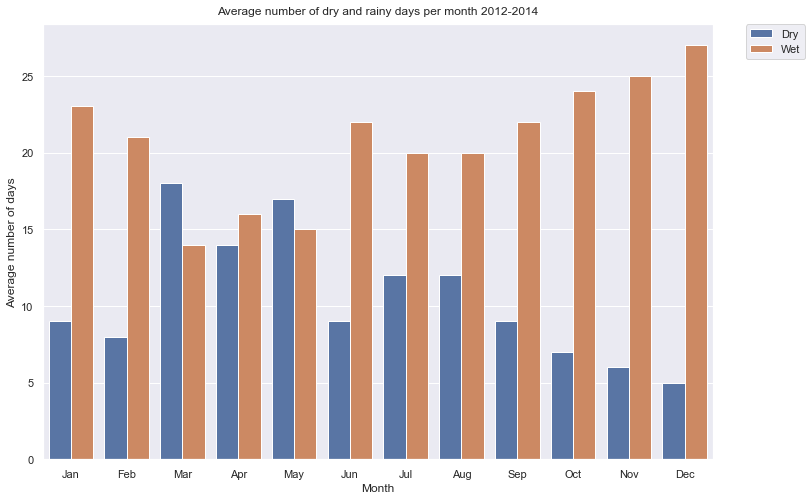

In [76]:
# Set style, context and colour pallette
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
sns.set_palette(sns.color_palette("bright"))
sns.set()

# Barplot generation
plot = sns.barplot(
        x="month_name", 
        y="date", 
        hue="is_rain", 
        data=rain_data.sort_values(['month_name', 'is_rain']),
        order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
    )
# Set axis, titles and legend
plt.xlabel("Month")
plt.ylabel("Average number of days")
plt.title('Average number of dry and rainy days per month 2012-2014', pad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

***Figure Description:*** This bar plot shows the average number of rainy and dry days per month over the years 2012,2013 and 2014. We can conclude that Copenhagen has a heavy amount of precipitation. On average for this period of time, we can see that March and May are the only months having fewer rainy than dry days. Bear in mind that the slightest precipitation per day counts as a rainy day.

**Code Process 3/3:** Implementation of part 3.

The following code generates calendar based heatmaps that show the amount of precipitation, heat and windspeed per day over the years included in the dataset for this project. Code comments provide more detail on the implementation.

In [77]:
# Define collected years
years = [2012, 2013, 2014]

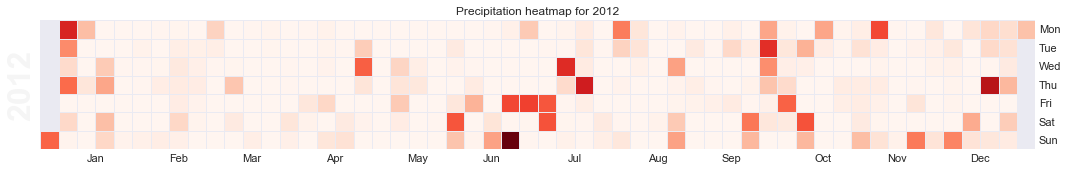

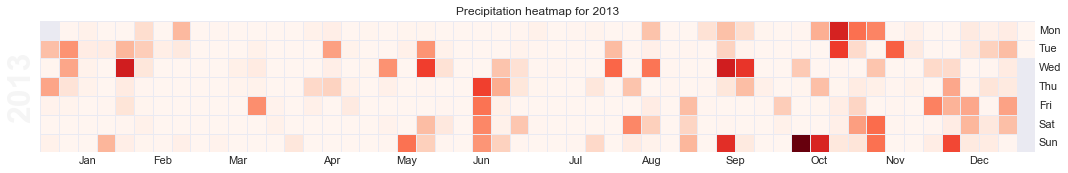

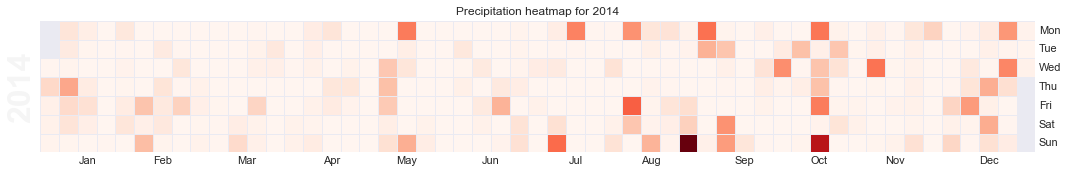

In [78]:
# Loop over the different years for to generate heatmap for each year
# Precipitation
for year in years:
    temp_weather = weather_data[weather_data['year']==year]
    rain_temp = pd.DataFrame(temp_weather[['datetime', 'precip']])
    rain_temp['datetime'] = pd.to_datetime(rain_temp.datetime, format="%y%m%d")

    rain_temp = rain_temp.set_index('datetime')
    fig, ax = calmap.calendarplot(rain_temp['precip'], fig_kws={"figsize":(15,4)}, subplot_kws={'title': 'Precipitation heatmap for '+str(year)})

**Figure Description:** 
This calendar-based heatmap provides an overview of the precipitation in the years 2012, 2013, and 2014. The year for each one is indicated with a watermark on the left vertical axes, the month is indicated on the horizontal axis, and the weekday on the right vertical axis. We can see that on average mid-February and until the beginning of May the precipitation seems to be light. However we start to see increased heavy precipitation days during the autumn months.

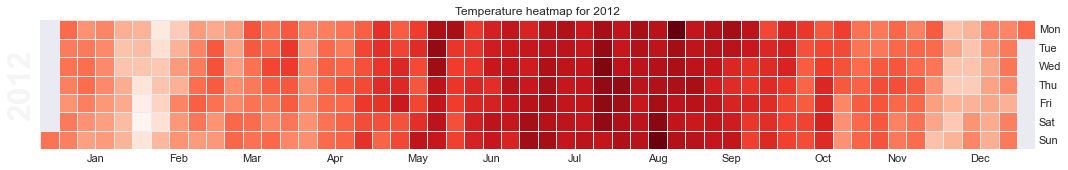

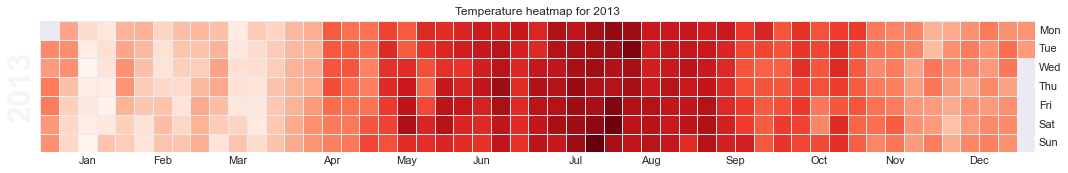

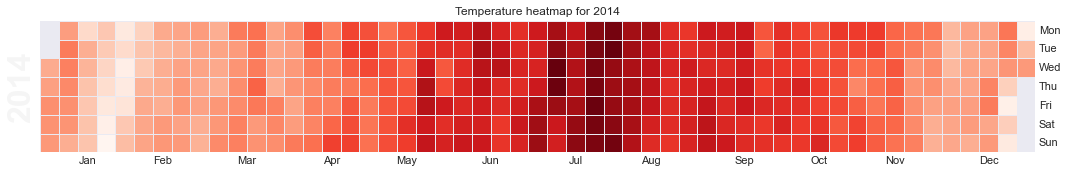

In [79]:
# Loop over the different years for to generate heatmap for each year
# Temperture
for year in years:
    temp_weather = weather_data[weather_data['year']==year]
    heat_temp = pd.DataFrame(temp_weather[['datetime', 'temp']])
    heat_temp['datetime'] = pd.to_datetime(heat_temp.datetime, format="%y%m%d")

    heat_temp = heat_temp.set_index('datetime')
    fig, ax = calmap.calendarplot(heat_temp['temp'], fig_kws={"figsize":(15,4)}, subplot_kws={'title': 'Temperature heatmap for '+str(year)})

**Figure Description:** 
This calendar-based heatmap provides an overview of the temperture in the years 2012, 2013, and 2014. The year for each one is indicated with a watermark on the left vertical axes, the month is indicated on the horizontal axis, and the weekday on the right vertical axis. We can see that all the years follow a similar pattern with the lowest temperatures being in January and Febrary and the yearly high being from mid-July to mid-August.

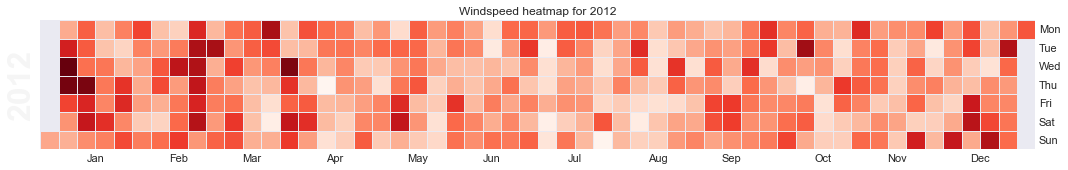

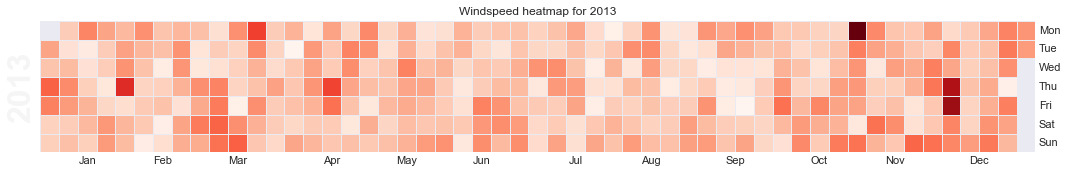

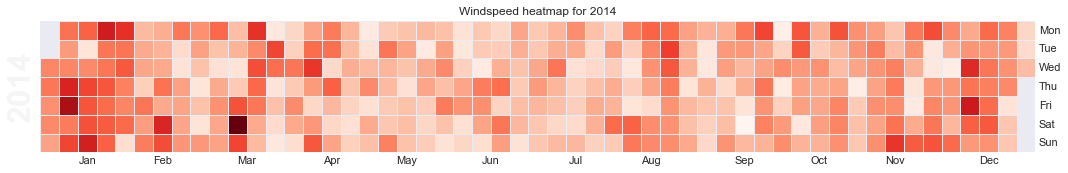

In [80]:
# Loop over the different years for to generate heatmap for each year
# Windspeed
for year in years:
    temp_weather = weather_data[weather_data['year']==year]
    wind_temp = pd.DataFrame(temp_weather[['datetime', 'windspeed']])
    wind_temp['datetime'] = pd.to_datetime(wind_temp.datetime, format="%y%m%d")

    wind_temp = wind_temp.set_index('datetime')
    fig, ax = calmap.calendarplot(wind_temp['windspeed'], fig_kws={"figsize":(15,4)}, subplot_kws={'title': 'Windspeed heatmap for '+str(year)})
    

**Figure Description:** 
This calendar-based heatmap provides an overview of the wind speed in the years 2012, 2013, and 2014. The year for each one is indicated with a watermark on the left vertical axes, the month is indicated on the horizontal axis, and the weekday on the right vertical axis. It is harder to obtain some specific patterns that apply for all years when analyzing the wind speed. The only interesting remark might be that January and February are extremely windy for both 2012 and 2014. 

#### 3.2.6: Basic Stats - Traffic Data

The following subsection will cover the basic statistics of the bike and car traffic data.

***Summary***: The following section will cover the main aspects of the bike and car traffic datasets over the selected period of time (2012-2013-2014). We will look into some basic statistics for each year along with the daily traffic count. The following list will provide you with an overview of what this subsection will be covering.

1. Bicycle Data
    - Basic stats on traffic count
    - Daily traffic count
    
2. Car Data
    - Basic stats on traffic count
    - Daily traffic count  
    
3. Traffic distribution per day visualized in a histogram

***Tools***:

1. ``pd.describe()`` For a basic stats overview of the selected data

2. ``sns.boxplot()``for visualization creation of daily traffic count

3. ``sns.hist()``for visualization creation of number of bikes/cars

**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/3:** Implementation of part 1. 

The following code generates general statistics on the bike traffic data for each year in the dataset. Follow code comments for closer detail.

In [81]:
# function to generate basic stats on yearly basis using .describe()
def print_bicycle_stats(year):
    print('{}\n{}'.format(year, 40*'-'))
    print(bicycle_data[bicycle_data['year'] == year]['total'].describe())
    print('\n')

# yearly stats
print_bicycle_stats(2012)
print_bicycle_stats(2013)
print_bicycle_stats(2014)

2012
----------------------------------------
count     6599.000000
mean      5275.680406
std       5151.641425
min         46.000000
25%       1553.500000
50%       3326.000000
75%       7535.500000
max      33053.000000
Name: total, dtype: float64


2013
----------------------------------------
count     9513.000000
mean      4093.889625
std       5032.197535
min          0.000000
25%        920.000000
50%       2026.000000
75%       5661.000000
max      36097.000000
Name: total, dtype: float64


2014
----------------------------------------
count     7509.000000
mean      4612.464509
std       5771.209027
min          0.000000
25%        590.000000
50%       2206.000000
75%       7004.000000
max      35407.000000
Name: total, dtype: float64




***Result comments:***  This report provides an overview of the bike traffic for each year of our data. We can see that 2013 has the most non-empty observations, on average the bike traffic was heaviest in 2012 with an average of 5275 bikes per day, and finally, we can see that 2013 holds the value for the busiest bike traffic day with 36097 bikes for one day!

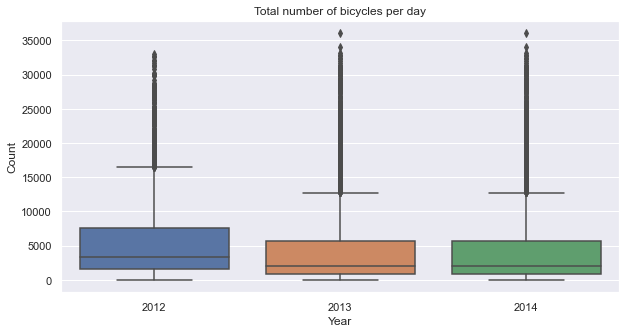

In [82]:
box_dict = {'2012': bicycle_data[bicycle_data['year'] == 2012]['total'],
           '2013': bicycle_data[bicycle_data['year'] == 2013]['total'],
           '2014': bicycle_data[bicycle_data['year'] == 2014]['total']}

fig = plt.figure(figsize=(10,5))
sns.boxplot(data=[box_dict['2012'], box_dict['2013'], box_dict['2013']])
plt.xticks(ticks=[0,1,2], labels=box_dict.keys())
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total number of bicycles per day')
plt.show()

***Figure Description:*** This boxplot shows the distirbution of number of bicycles per day each year. They reflect identically on the basic stats above. You can see that 2013 has the most signifigant outlier indicating the busiest day for the entire data. 2012 has the highest median and 2013 has the lowest median.

**Code Process 2/3:** Implementation of part 2. 

The following code generates general statistics on the car traffic data for each year in the dataset. Follow code comments for closet detail.

In [83]:
def print_cars_stats(year):
    print('{}\n{}'.format(year, 40*'-'))
    print(car_data[car_data['year'] == year]['total'].describe())
    print('\n')
    
print_cars_stats(2012)
print_cars_stats(2013)
print_cars_stats(2014)

2012
----------------------------------------
count     4779.000000
mean     15707.061938
std      12744.397524
min        443.000000
25%       3901.000000
50%      12072.000000
75%      26837.500000
max      45748.000000
Name: total, dtype: float64


2013
----------------------------------------
count     4954.000000
mean     15351.647961
std      12496.969778
min          0.000000
25%       4113.500000
50%      12317.500000
75%      25607.000000
max      45594.000000
Name: total, dtype: float64


2014
----------------------------------------
count     4450.000000
mean     13450.735281
std      11316.352084
min          0.000000
25%       3851.250000
50%       9179.000000
75%      21376.000000
max      45115.000000
Name: total, dtype: float64




***Result comments:***  This report provides an overview of the car traffic for each year of our data. We can see that 2012 has the most non-empty observations, on average the bike traffic was heaviest in 2012 with an average of 15707 bikes per day, and finally, we can see that 2012 also holds the value for the busiest car traffic day with 45748 cars for one day!

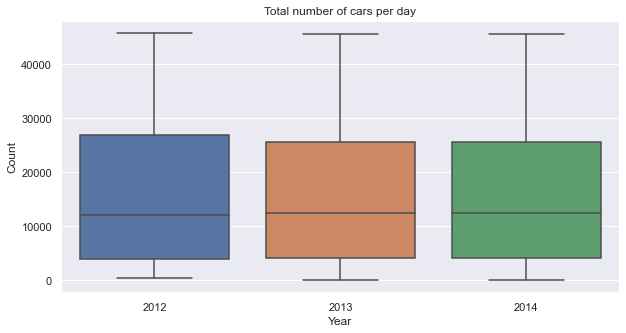

In [84]:
box_dict = {'2012': car_data[car_data['year'] == 2012]['total'],
           '2013': car_data[car_data['year'] == 2013]['total'],
           '2014': car_data[car_data['year'] == 2014]['total']}

plt.figure(figsize=(10,5))
sns.boxplot(data=[box_dict['2012'], box_dict['2013'], box_dict['2013']])
plt.xticks(ticks=[0,1,2], labels=box_dict.keys())
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total number of cars per day')
plt.show()

***Figure Description:*** This boxplot shows the distribution of the number of cars per day each year. They reflect identically on the basic stats above. 2012 has the highest mean and 2014 has the lowest mean. Overall we can conclude that the car data is more evenly distributed over the three years of measurements, the statistical difference is insignificant in between years.

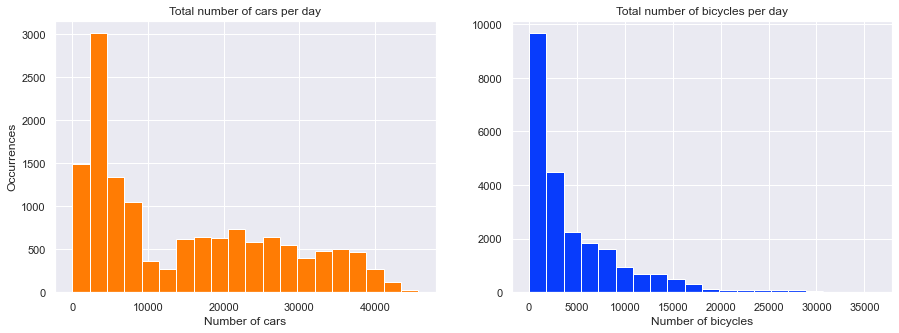

In [85]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist(car_data['total'], bins=20, color='#ff7c04')
ax[0].set_ylabel('Occurrences')
ax[0].set_xlabel('Number of cars')
ax[0].set_title('Total number of cars per day')
ax[1].hist(bicycle_data['total'], bins=20, color='#083cfc')
ax[1].set_title('Total number of bicycles per day')
ax[1].set_xlabel('Number of bicycles')
plt.show()

***Figure Description:*** These subplots show the distribution of traffic count values for our entire data. The one to the right is for car traffic and the one to the left for bike traffic.

***Result Comments:*** It is interesting to see that the lowest bin value is the most frequently occurring one for the bike count at closely three times more frequent than the second-lowest bin value for the car traffic.

## Part 4: Data Analysis

This section will cover the data analysis and visualizations generated to support the processes along with discussions about our machine learning model.

### 4.1 Measurement locations and geopatterns

#### 4.1.1 Measurement Locations

***Summary***: The following section will give an overview of the measurement locations in the data set; showing each and every measurement location and if they measure bike traffic, car traffic or both.

***Tools***:

1. ``Folium``: Used to generate a map using the geoproperties of our dataset.

**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/2:** The first step towards generating the map for all measurement locations is defining separate dataframes for bike and car data and collecting their geographical properties. Finally, the latitude coordinate for the car data is slightly adjusted so the markers don't end up on top of each other when locations both measure car and bike traffic.

In [86]:
# Collecting the geographical properties of the data
df = bicycle_data.groupby(['Vejnavn','lat', 'lon'], as_index=False).mean()
car_df = car_data.groupby(['Vejnavn', 'lat', 'lon'], as_index=False).mean()

loc = df[['Vejnavn', 'lat','lon']]
car_loc = car_df[['Vejnavn', 'lat', 'lon']]

In [87]:
# Adjust so that markers don't end up on top of each other when it is bor bike and car location
car_loc['lat'] *= 1.00001


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Code Process 2/2:** The following code iterates over the locations and marks if they hold bike measurements, car measurements or both to place on the folium map. Finally the figure is saved.

In [88]:
# Shortcut of the next cell
map_cph = folium.Map(location=[55.676098, 12.568337],
                    zoom_start = 11)

for i, l in loc.iterrows():
    folium.Marker([l['lat'], l['lon']],
                    popup=l['Vejnavn'],
                    icon=folium.Icon(color='green', prefix='fa', icon='bicycle')
                    ).add_to(map_cph)

for i, l in car_loc.iterrows():
    folium.Marker([l['lat'], l['lon']],
                    popup=l['Vejnavn'],
                    icon=folium.Icon(color='red', prefix='fa', icon='car'),
                    
                    ).add_to(map_cph)

map_cph

***Figure Description:*** This map shows all measurement locations and if they measure car traffic, bike traffic or both. 

In [89]:
map_cph.save('map.html')

#### 4.1.2 Traffic distribution per measurement locations


***Summary***: The following section will give an overview of traffic distribution at a weekly and monthly level for each measurement location in the data set. First for bikes and then for cars. This is to indicate if any locations should be dismissed due to missing data or measurements. This will also help indicate if there are specific patterns for different locations or if the behavior is similar over temporal patterns for all locations.

***Tools***:

1. ``Seaborn``: Used for plot generation of temporal patterns

2. ``Matplotlib``: Used for plot generation of temporal patterns


**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*


##### 4.1.2.1 Bikes

**Code Process 1/3:** Data preperation see code comments for closer details.

In [90]:
weather_data['date_'] = pd.to_datetime(weather_data['datetime']).dt.date

In [91]:
bicycle_data['day_of_week'] = bicycle_data['Dato'].apply(lambda x: x.weekday())
car_data['day_of_week'] =car_data['Dato'].apply(lambda x: x.weekday())

In [92]:
# Create name columns for months and weekdays
bicycle_data['Month_name'] = bicycle_data['month'].apply(lambda x: calendar.month_abbr[x])
bicycle_data['weekday_name'] = bicycle_data['day_of_week'].apply(lambda x: calendar.day_abbr[x])
car_data['Month_name'] = car_data['month'].apply(lambda x: calendar.month_abbr[x])
car_data['weekday_name'] = car_data['day_of_week'].apply(lambda x: calendar.day_abbr[x])

**Code Process 2/3:** Barplots on monthly level per measurement location, see code comments for closer details.

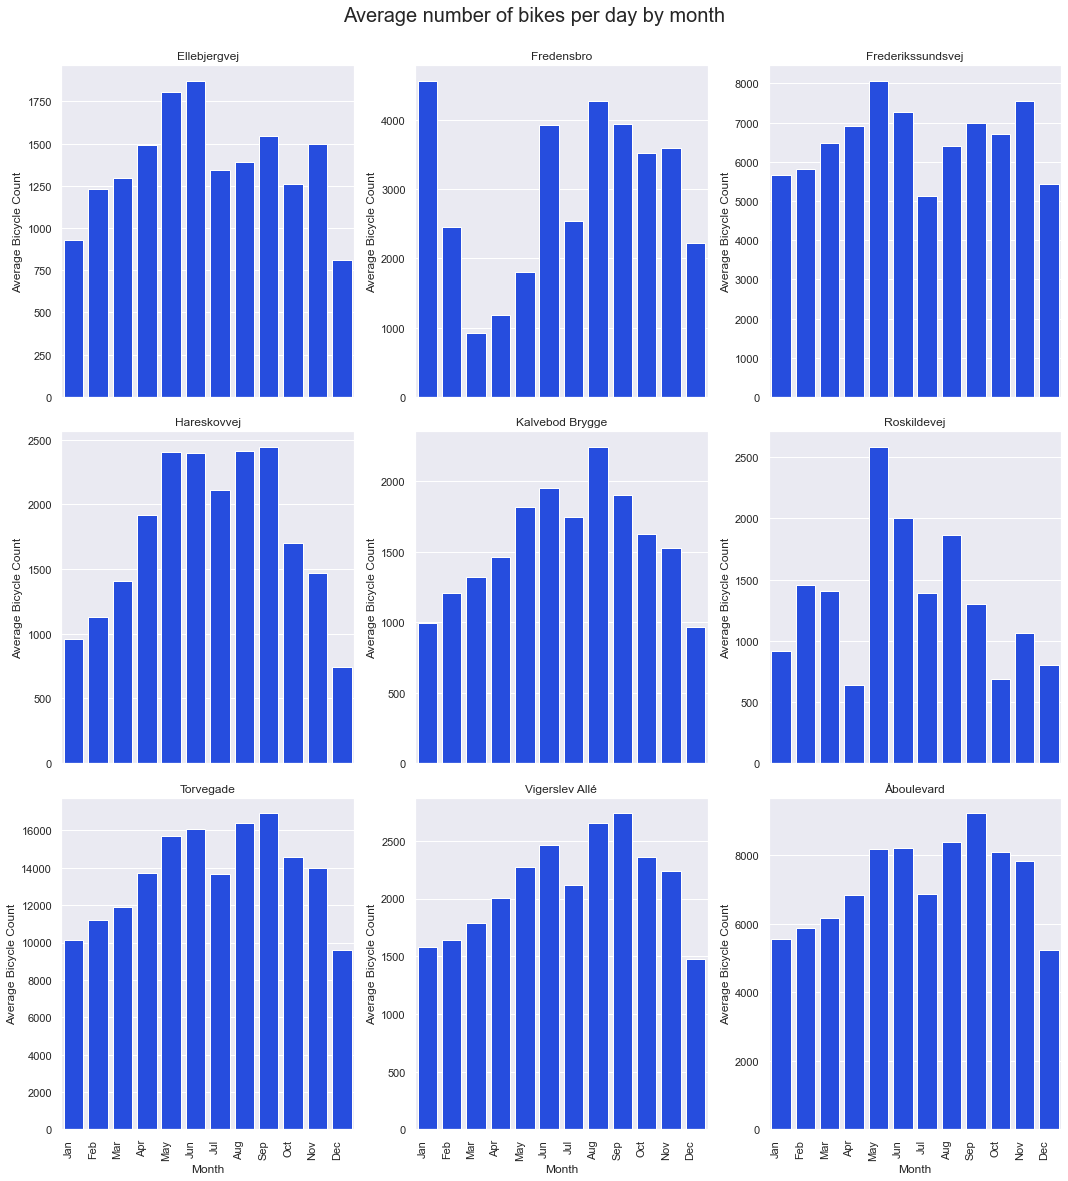

In [93]:
# defining a fig,axis placeholder for the subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,20), sharex=True)

#get the name of the route
vejnavn = sorted(bicycle_data['Vejnavn'].unique())

# loop throught the routenames to create a subplo per each
for i, vej in enumerate(vejnavn):
    # using the grouped/pivotted table as source
    plt.title(vej)
    sns.barplot(
        x="Month_name", 
        y="total",  
        data=bicycle_data[bicycle_data['Vejnavn'] == vej],
        color='#083cfc',
        ci=None,
        ax=axes[i//3,i%3]
    ).set(title=vej)

for ax in axes.flat:
    ax.set(xlabel='Month', ylabel='Average Bicycle Count')
    
fig.suptitle('Average number of bikes per day by month', size = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.autofmt_xdate(rotation=90)
plt.show()

*__Figure Description:__* Average daily bike traffic in each month at each counting post. Note that the y-axes have different scales.

***Result Comments:***
There are no real surprises here. There is less traffic during the winter, and more during the summer. At most stations though, there is a drop in traffic in July. Two stations, Fredensbro and Roskildevej, stand out because the patterns there look quite different and less regulated than the other stations.

Let's now look at the patterns for the weekdays.

**Code Process 3/3:** Barplots on weekly level per measurement location, see code comments for closer details.

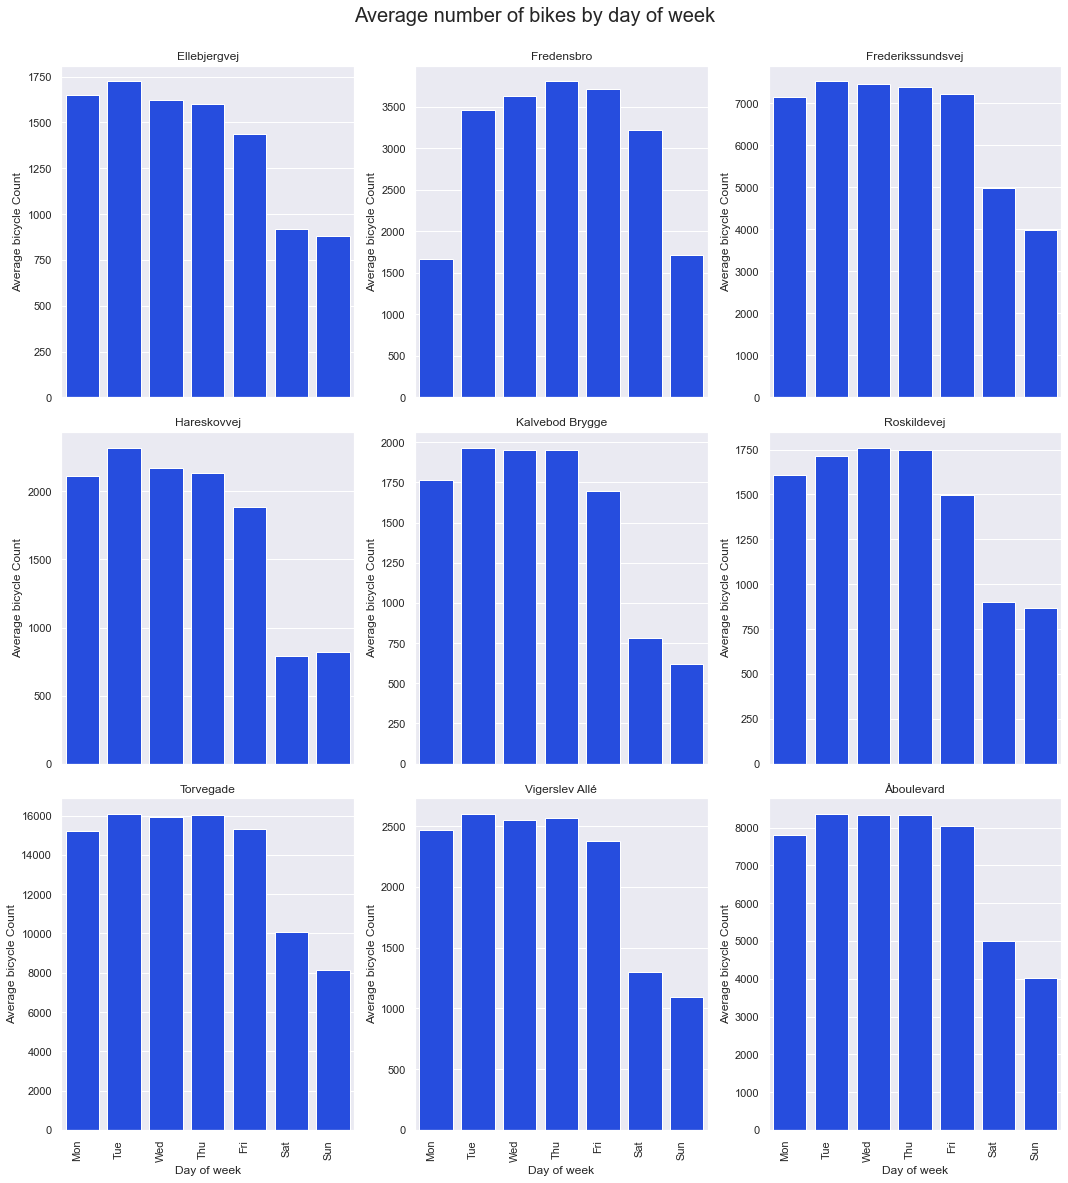

In [94]:
# defining a fig,axis placeholder for the subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,20), sharex=True)
# Count per each crime and day -column definition for plotting
bicycle_data_s = bicycle_data.sort_values('day_of_week')
# loop throught the focuscrimes to create a subplo per each
for i, vej in enumerate(vejnavn):
    plt.title(vej)
    sns.barplot(
        x="weekday_name", 
        y="total",  
        data=bicycle_data_s[bicycle_data_s['Vejnavn'] == vej],
        color='#083cfc',
        ci=None,
        ax=axes[i//3,i%3]
    ).set(title=vej, xlabel=None)
    

for ax in axes.flat:
    # Set axis labels according to Anna's example plots
    ax.set(xlabel='Day of week', ylabel='Average bicycle Count')

fig.suptitle('Average number of bikes by day of week', size = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.autofmt_xdate(rotation=90)
plt.show()

*__Figure Description:__* Average daily bicycle traffic for each of the seven weekdays, at each counting post. Note that the y-axes have different scales.

***Result Comments:*** There is notably less traffic during the weekends on every counting post, except for Fredensbro, which has less traffic on Sundays and Mondays. Otherwise, the distribution is pretty similar everywhere.

Now that we have visualised the bicycle traffic, the next step is to do the same for the car traffic.

##### 4.1.2.2 Cars
***Note**: *The code process follows the same implementation as in section 4.1.2.1 but for the car data.* 

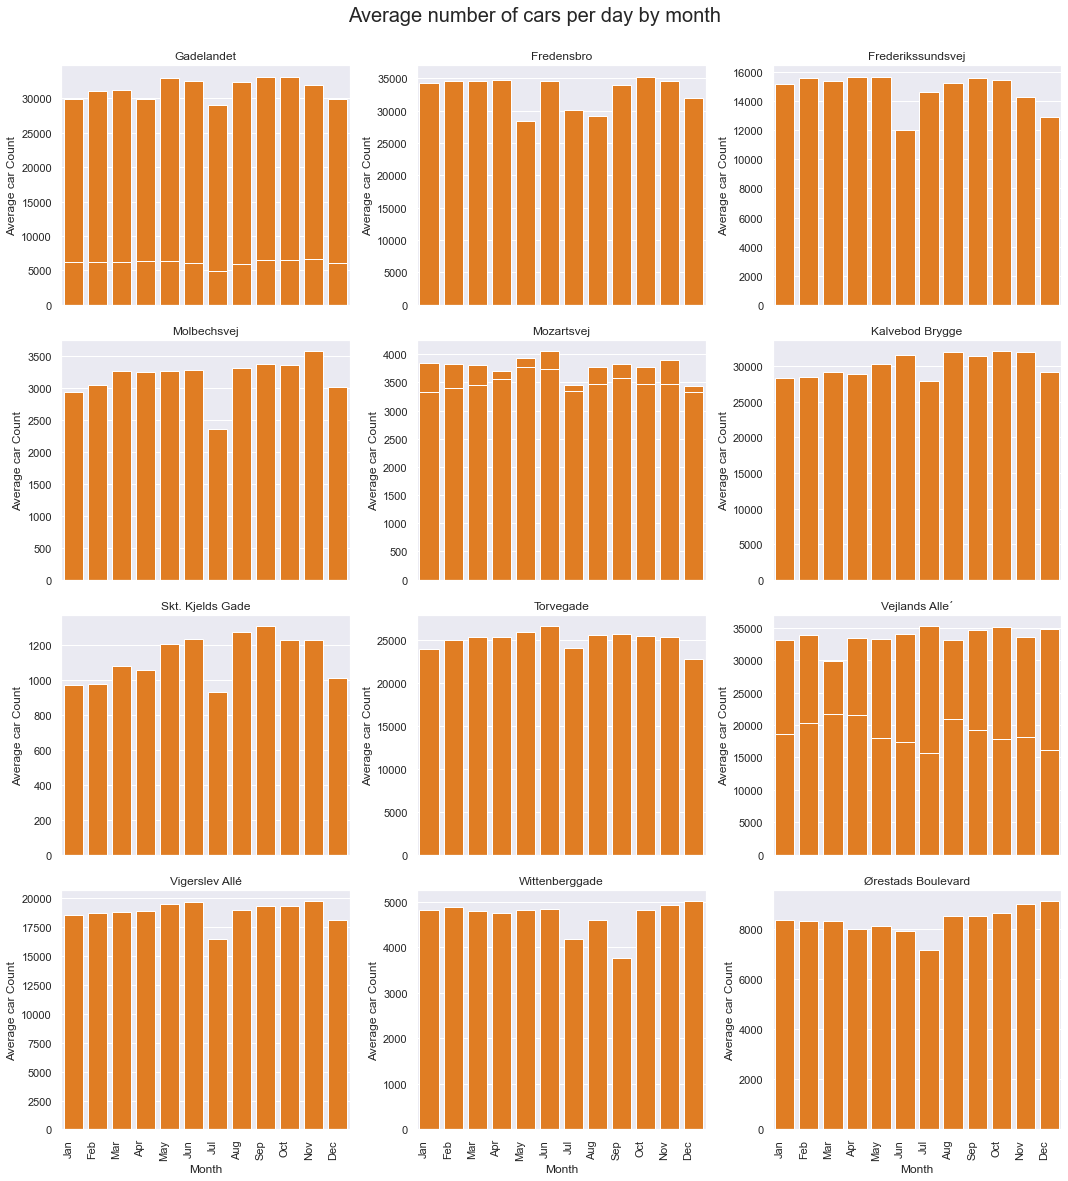

In [95]:
# defining a fig,axis placeholder for the subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20), sharex=True)

car_vejnavn = sorted(car_data['Vejnavn'].unique())

# loop throught the focuscrimes to create a subplo per each
for i, vej in enumerate(car_vejnavn):
    # using the grouped/pivotted table as source
    plt.title(vej)
    sns.barplot(
        x="Month_name", 
        y="total",  
        data=car_data[car_data['Vejnavn'] == vej],
        color='#ff7c04',
        ci=None,
        ax=axes[i//4,i%3]
    ).set(title=vej)

for ax in axes.flat:
    # Set axis labels according to Anna's example plots
    ax.set(xlabel='Month', ylabel='Average car Count')

fig.suptitle('Average number of cars per day by month', size = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.autofmt_xdate(rotation=90)
plt.show()

*__Figure Description:__* Average daily car traffic in each month at each counting post. Note that the y-axes have different scales.

***Result Comments:***
The distribution of the car traffic is a bit more uniform than that of the bike traffic. There are still drops in certain months, most often in July, just like in the bicycle data. There is no distribution here that is trivially different than the others.

Let's now investigate the car traffic on a weekday basis.

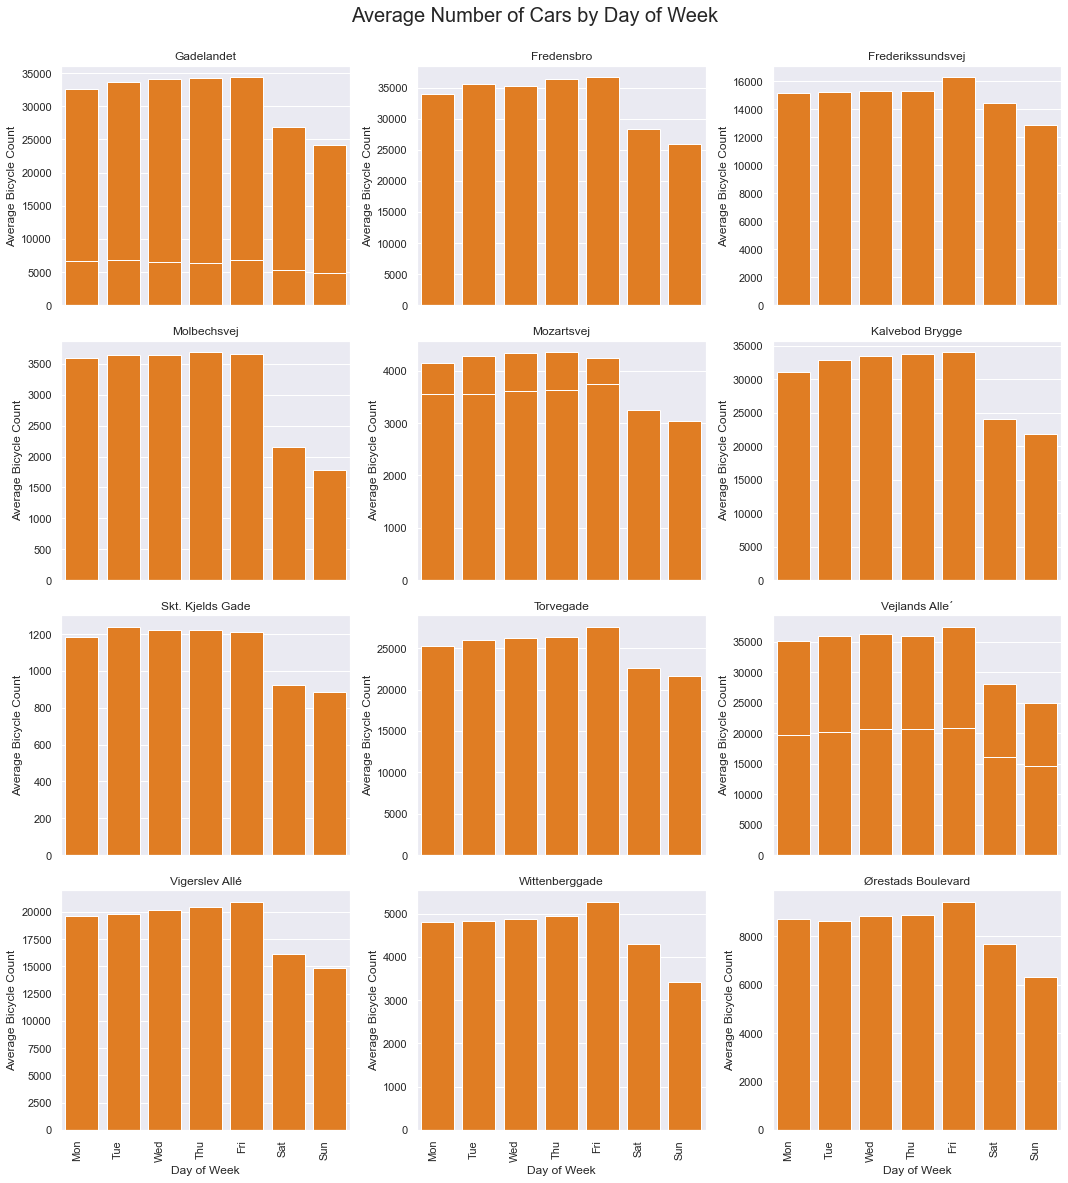

In [96]:
# defining a fig,axis placeholder for the subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20), sharex=True)

car_data_s = car_data.sort_values('day_of_week')

# loop throught the focuscrimes to create a subplo per each
for i, vej in enumerate(car_vejnavn):
    plt.title(vej)
    sns.barplot(
        x="weekday_name", 
        y="total",  
        data=car_data_s[car_data_s['Vejnavn'] == vej],
        color='#ff7c04',
        ci=None,
        ax=axes[i//4,i%3]
    ).set(title=vej, xlabel=None)
    

for ax in axes.flat:
    # Set axis labels according to Anna's example plots
    ax.set(xlabel='Day of Week', ylabel='Average Bicycle Count')

fig.suptitle('Average Number of Cars by Day of Week', size = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.autofmt_xdate(rotation=90)
plt.show()

__Figure Description:__ Average daily car traffic for each of the seven weekdays, at each counting post. Note that the y-axes have different scales.

***Result Comments:***
This is quite similar to the bicycle data, as there is notably less traffic on the weekdays. There is no counting station here that stands out as different to the others.

### 4.2 Temporal Traffic Patterns and Weather Effects

Since we are now familiar with the distributions of car and bike traffic for each measurement location and how they differentiate over months and weekdays we want to visualize the temporal traffic patterns and compare the bike and car count for each point in time.


#### 4.2.1  Temporal Traffic Patterns

***Summary:*** Looking into the temporal traffic patterns and comparing the average number of bikes vs cars will give us a deeper understanding of how the traffic is distributed. The measurement locations are irrelevant for this analysis, the plots show an average for all location posts in Copenhagen at the given time. All plots generated in this section are interactive so you can hover, zoom and select properties to analyze.

***Tools:***
1. ``Bokeh``: The Bokeh package is used to generate interactive stacked barplot for comparison of bikes and cars.


**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/5:** This package usage enables Bokeh plot generation in a Jupyter notebook.

In [97]:
# Bokeh plots
output_notebook()

Loading BokehJS ...

**Code Process 2/5:** Hourly plot implementation. The following code processes the data to be able to average overall measurements for bikes and cars per hour of the day for all locations. So for example the bar at 00-01 shows the average bike and car traffic overall measurement locations at that given time. After the data prep, the figure is defined and the data is gathered for each vertical bar. Finally, the legend-click policy and hovering tool are enabled along with enhancing the plot to make it more enjoyable for the end-user. See code comments for closer detail

In [98]:
# Drop unnecassary columns
merge_car = car_data.drop(columns = ['Vej-Id', 'Dato', 'lat', 'lon', 'total', 'year', 'month', 
                                     'date', 'day_of_week', 'Month_name', 'weekday_name'])
merge_bicycle = bicycle_data.drop(columns = ['Vej-Id', 'Dato', 'lat', 'lon', 'total', 'year', 'month', 
                                     'date', 'day_of_week', 'Month_name', 'weekday_name'])
# Group by location and take the average of measurements
merge_car = merge_car.groupby(['Vejnavn']).mean().reset_index()
merge_bicycle = merge_bicycle.groupby(['Vejnavn']).mean().reset_index()

# turn columns to values and vice-versa
merge_car = merge_car.melt(id_vars=["Vejnavn"], 
                            var_name="Time", 
                            value_name="cars")
merge_bicycle = merge_bicycle.melt(id_vars=["Vejnavn"], 
                            var_name="Time", 
                            value_name="bikes")
# merge datasources
merge_data = merge_car.merge(
                        merge_bicycle, 
                        left_on=['Vejnavn', 'Time'], 
                        right_on=['Vejnavn', 'Time'])#.drop(columns = 'Vejnavn')



# Drop all rows with 0 measurements for either bikes or cars, dismissing the stations
merge_data = merge_data[(merge_data != 0).all(1)].groupby(['Time']).mean().reset_index()

# Daily AVG
#merge_data['bikes'] = merge_data['bikes']/(365*3)
#merge_data['cars'] = merge_data['cars']/(365*3)

# define columns for the plot along with colours and legend labels
v_bar_cols = ['cars', 'bikes']
color_list = ['#ff7c04', '#083cfc']
legends = ['Cars', 'Bikes',]

# define a source for the bokeh
source3 = ColumnDataSource(data = merge_data)
# define an empty bokeh figure
p3 = figure(plot_width = 800, 
            plot_height = 500,
            title="Traffic by the hour",
            x_axis_label="Hour", 
            y_axis_label="Average count", 
            x_range=merge_data['Time'])


bar = {}
for indx,i in enumerate(v_bar_cols):
    bar[i] = p3.vbar(x='Time', top=i, source = source3, width = 0.5, color = color_list[indx])
# for legend alterations - outside of grid
items = [('cars', [bar[v_bar_cols[0]]]),
        ('bikes', [bar[v_bar_cols[1]]])]
# place legend outside grid
legend = Legend(items=items, location=(0, 360))
p3.legend.click_policy = "mute"
p3.add_layout(legend, 'left')
p3.xaxis.major_label_orientation = "vertical"

# hovertool implementation
p3.legend.click_policy = "mute"
# limit the hovering to the recommited crimes and 2 decimals
p3.add_tools(HoverTool(renderers=[bar['cars']],
                       tooltips=[("Number of cars", "@cars{1.11}"),
                                 ("Number of bikes", "@bikes{1.11}")]))



You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.



**Code Process 3/5:** Weekly and monthly plot implentation. The following code prepares the data needed to generate the monthly and weekly temporal pattern Bokeh plots. See code comments for closer detail

In [99]:
# weekly, monthly
drop_cols = ['Vej-Id', 'kl.00-01', 'kl.01-02', 'kl.02-03',
       'kl.03-04', 'kl.04-05', 'kl.05-06', 'kl.06-07', 'kl.07-08', 'kl.08-09',
       'kl.09-10', 'kl.10-11', 'kl.11-12', 'kl.12-13', 'kl.13-14', 'kl.14-15',
       'kl.15-16', 'kl.16-17', 'kl.17-18', 'kl.18-19', 'kl.19-20', 'kl.20-21',
       'kl.21-22', 'kl.22-23', 'kl.23-24', 'lat', 'lon',  'year', 'date']

# drop unnecessary columns
merge_car = car_data.drop(columns = drop_cols)
merge_bicycle = bicycle_data.drop(columns = drop_cols)

# merge car and bicycle data
temp_patt_org = merge_car.merge(
                        merge_bicycle, 
                        left_on=['Vejnavn', 'Dato', 'day_of_week', 'month', 'Month_name','weekday_name'], 
                        right_on=['Vejnavn', 'Dato', 'day_of_week', 'month', 'Month_name','weekday_name'])
temp_patt_org.rename(columns = {'total_x':'cars', 'total_y':'bikes'}, inplace = True)

# Drop all rows with 0 measurements for either bikes or cars, dismissing the stations
temp_patt = temp_patt_org[temp_patt_org.cars != 0]
temp_patt = temp_patt_org[temp_patt_org.bikes != 0]

**Code Process 4/5:** Weekly and monthly plot implentation. The function implemented in this code cell takes periods as input argument and groups the data accordingly, generating the associated temporal pattern Bokeh plots. After the data grouping, the figure is defined and the data is gathered for each vertical bar. Finally, the legend-click policy and hovering tool are enabled along with enhancing the plot to make it more enjoyable for the end-user. See code comments for closer detail.

In [100]:
# Function generating temporal bokeh plots based on input
def temporal_patterns(grouping, sort_col, title ,xax, yax):

    data = temp_patt.groupby([grouping, sort_col]).agg({'cars':'mean', 'bikes':'mean'}).reset_index().sort_values(sort_col)
    # define a source for the bokeh
    source = ColumnDataSource(data = data)
    # define an empty bokeh figure
    p = figure(plot_width = 800, 
                plot_height = 500,
                title = title,
                x_axis_label = xax, 
                y_axis_label = yax, 
                x_range=data[grouping])


    bar = {}
    for indx,i in enumerate(v_bar_cols):
        bar[i] = p.vbar(x=grouping, top=i, source = source, width = 0.5, color = color_list[indx])
    # for legend alterations - outside of grid
    items = [('cars', [bar[v_bar_cols[0]]]),
            ('bikes', [bar[v_bar_cols[1]]])]
    # place legend outside grid
    legend = Legend(items=items, location=(0, 360))
    p.legend.click_policy = "mute"
    p.add_layout(legend, 'left')
    p.xaxis.major_label_orientation = "vertical"

    # hovertool implementation
    p.legend.click_policy = "mute"
    # limit the hovering to the recommited crimes and 2 decimals
    p.add_tools(HoverTool(renderers=[bar['cars']],
                           tooltips=[("Number of cars", "@cars{1.11}"),
                                     ("Number of bikes", "@bikes{1.11}")]))

    return p

**Code Process 5/5:** The following code block simply uses the previously implemented functions to generate hourly, weekly and monthly temporal pattern Bokeh plots for comparing the bike and car traffic. See code comments for closer detail

In [101]:
curdoc().clear()

# define layout for each: hourly, weekly and monthly
l1 = layout([[p3]], sizing_mode='fixed')
l2 = layout([[temporal_patterns('Month_name', 'month', 'Traffic by the month', 'Month', 'Average count')]], sizing_mode='fixed')
l3 = layout([[temporal_patterns('weekday_name', 'day_of_week', 'Traffic by the week', 'Weekday', 'Average count')]], sizing_mode='fixed')

# create tab for each: hourly, weekly and monthly
tab1 = Panel(child=l1,title="Hourly")
tab2 = Panel(child=l3,title="Weekly")
tab3 = Panel(child=l2,title="Monthly")
tabs = Tabs(tabs=[tab1, tab2, tab3])

# clear and add roots for the bokeh plot
curdoc().clear()
curdoc().add_root(tabs)

# print output file, save and display
output_file('temp_patt.html')
save(tabs)

show(tabs)

***Figure Description:*** These Bokeh plots show the average traffic count per hour (tab1), weekday (tab2) and month (tab3).The plot is interactive so feel free to explore the result in more detail.

***Result Comments:*** 

* Hourly: Looking at the hourly distribution it is noticeable that the traffic load clearly follows the busy hours around 7-9 and 15-17 when people are commuting from to/from work and school. The bike count is significantly lower than the car count
* Weekly: Looking at the weekly distribution it is noticeable that the bike traffic is way more consistent over the week compared to the car traffic which has more drastic drops on weekends. The bike count is overall significantly lower than the car count.
* Monthly: The monthly car average stays fairly consistent for the car data overall months while the monthly average variates more for the bikes, having the lowest average in January which is nearly half of the highest average in August.

#### 4.2.2 Temporal Traffic Patterns and Weather Affects

***Summary:*** Seeing how the traffic is oriented over different temporal patterns might spike the question if the weather data that we have collected for this project can show us any correlation between extreme weather conditions and bike traffic. Let's have a look at this problem. We will look into traffic patterns on dates rainy days, dry days, windy days: windspeed over 40, and hot days: temperature over 16°C.

***Tools:***
1. ``Bokeh``: The Bokeh package is used to generate interactive stacked barplot for comparison of bikes and cars.


**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

**Code Process 1/2:** The following code cell creates temporary weather dataframes holding lines meeting the weather requirements listed in the summary chaper above. Finally 0 lines are dropped from the traffic data.

In [103]:
# rain 
rain_df = weather_data[weather_data['rain'] == True]
rain_df['datetime'] = rain_df['datetime'].astype(str)
# dry weather
dry_df = weather_data[weather_data['rain'] == False]
dry_df['datetime'] = dry_df['datetime'].astype(str)
# heat over 16
heat_df = weather_data[weather_data['feelslike'] > 16]
heat_df['datetime'] = heat_df['datetime'].astype(str)
# wind gusts over 40
wind_df = weather_data[weather_data['windspeed'] > 40]
wind_df['datetime'] = wind_df['datetime'].astype(str)
# data correction before df merge
temp_patt_org['Dato'] = temp_patt_org['Dato'].astype(str)
temp_patt_org = temp_patt_org[temp_patt_org.cars != 0]
temp_patt_org = temp_patt_org[temp_patt_org.bikes != 0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

**Code Process 2/2:** Weather conditions and traffic interplay plot implentation. The function implemented in this code cell takes weather dataframes as input argument and  groups the joint weather and traffic data accordingly. After the data grouping, the figure is defined and the data is gathered for each vertical bar. Finally, the legend-click policy and hovering tool are enabled along with enhancing the plot to make it more enjoyable for the end-user. See code comments for closer detail.

In [104]:
def weather_traffic(weather_df, title, xax, yax):

    data = weather_df.merge(
                        temp_patt_org, 
                        how = 'left',
                        left_on=['datetime', 'month', 'day_of_week'], 
                        right_on=['Dato', 'month', 'day_of_week']).drop(columns = ['name', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
                                                       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
                                                       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
                                                       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
                                                       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
                                                       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations',
                                                        'is_rain', 'rain', 'year', 'date', 'day_of_week','bussiness_day', 
                                                        'wet_cycling', 'Vejnavn', 'weekday_name'])
    
    data = data.groupby(['Month_name', 'month']).agg({'cars':'mean', 'bikes':'mean'}).reset_index().sort_values('month')
    # define a source for the bokeh
    source = ColumnDataSource(data = data)
    # define an empty bokeh figure
    p = figure(plot_width = 800, 
                plot_height = 500,
               
                title=title,
                x_axis_label=xax, 
                y_axis_label=yax, 
                x_range=data['Month_name'])


    bar = {}
    for indx,i in enumerate(v_bar_cols):
        bar[i] = p.vbar(x='Month_name', top=i, source = source, width = 0.5, color = color_list[indx])
    # for legend alterations - outside of grid
    items = [('cars', [bar[v_bar_cols[0]]]),
            ('bikes', [bar[v_bar_cols[1]]])]
    # place legend outside grid
    legend = Legend(items=items, location=(0, 360))
    p.legend.click_policy = "mute"
    p.add_layout(legend, 'left')
    p.xaxis.major_label_orientation = "vertical"

    # hovertool implementation
    p.legend.click_policy = "mute"
    # limit the hovering to the recommited crimes and 2 decimals
    p.add_tools(HoverTool(renderers=[bar['cars']],
                           tooltips=[("Number of cars", "@cars{1.11}"),
                                     ("Number of bikes", "@bikes{1.11}")]))

    return p
    


curdoc().clear()

l1 = layout([weather_traffic(rain_df, 'Daily average by months on rainy days', 'Month', 'Daily average')], sizing_mode='fixed')
l2 = layout([weather_traffic(dry_df, 'Daily average by months on dry days', 'Month', 'Daily average')], sizing_mode='fixed')
l3 = layout([weather_traffic(wind_df, 'Daily average by months on windy days', 'Month', 'Daily average')], sizing_mode='fixed')
l4 = layout([weather_traffic(heat_df, 'Daily average by months on hot days', 'Month', 'Daily average')], sizing_mode='fixed')
#l5 = layout([weather_traffic(low_wind_df, 'Daily average by months on non-windy days', 'Month', 'Daily average')], sizing_mode='fixed')
#l6 = layout([weather_traffic(low_heat_df, 'Daily average by months on cold days', 'Month', 'Daily average')], sizing_mode='fixed')


tab1 = Panel(child=l1,title="Rainy Days")
tab2 = Panel(child=l2,title="Dry Days")
tab3 = Panel(child=l3,title="Windy Days >40mph")
tab4 = Panel(child=l4,title="Hot Days >16°C")
#tab5 = Panel(child=l5,title="Non Windy Days - <40mph")
#tab6 = Panel(child=l6,title="Cold Days - <16°C")
tabs = Tabs(tabs=[tab1, tab2, tab3, tab4])


curdoc().clear()
curdoc().add_root(tabs)
output_file('weather_bokeh.html')
save(tabs)

show(tabs)
#bokeh_deepnote_show(tabs)

***Figure Description:*** These Bokeh plots show the average traffic count per month over the entire data given different weather conditions. The first tab shows rainy days, second tab shows dry days, third tab shows windy days and the fourth one shows hot days. The plot is interactive so feel free to explore the result in more detail.

***Result Comments:*** 
Comparing the different weather conditions we can see that both car and bike traffic stay fairly consistent for all weather conditions except for the hot days. On hot days the bike traffic seems to increase and stays significantly higher for the period of time. Section 4.3 will dive deeper into these results to find if there is a correlation between specific weather conditions and commute behaviour.

### 4.3 Is there a correlation between specific weather conditions and commute behaviour?

**Summary:** We now want to check if there is any difference in the traffic under different circumstances in the weather. We have selected three weather conditions, and will demonstrate the difference in traffic between low and high precipitation, windspeed and temperature.

***Tools:***
1. ``ttest_ind``: For testing  the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.
2. ``Matplotlib``: For slope chart figure generation.


**Note:** *The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.*

In [43]:
# Merge the traffic dataframes and the weather dataframes
cars_weather = car_data_s.merge(weather_data, left_on='Dato', right_on='date_')
bikes_weather = bicycle_data_s.merge(weather_data, left_on='Dato', right_on='date_')

We will look at the difference in traffic between those three conditions:

- __Precipitation:__ Precipitation vs. no precipitation
- __Windspeed:__ Windspeed over 40m/s vs. windspeed under 40m/s.
- __Temperature:__ Temperature over 16°C vs temperature under 16°C.

**Code Process 1/5:** Data processing to meet the conditions listed above.

In [44]:
# We have to add the columns for high windspeed and high temperature
# The column for rain vs. no rain already exists.

cars_weather['high_windspeed'] = cars_weather['windspeed'] > 40
cars_weather['high_temp'] = cars_weather['tempmax'] > 16

bikes_weather['high_windspeed'] = bikes_weather['windspeed'] > 40
bikes_weather['high_temp'] = bikes_weather['tempmax'] > 16

In [45]:
# Now get the pandas series for high and low
# We split by the weather condition and retrieve the total traffic per day.

cars_high_precip = cars_weather[cars_weather['rain'] == True]['total']
cars_low_precip = cars_weather[cars_weather['rain'] == False]['total']
cars_high_windspeed = cars_weather[cars_weather['high_windspeed'] == False]['total']
cars_low_windspeed = cars_weather[cars_weather['high_windspeed'] == True]['total']
cars_high_temp = cars_weather[cars_weather['high_temp'] == True]['total']
cars_low_temp = cars_weather[cars_weather['high_temp'] == False]['total']

**Code Process 2/5:** Null hypothesis testing using ttest_ind

In [46]:
# Perform a t-test to get a P-valueprint('Cars\n', 50*'-')
print('Precipitation P-value', ttest_ind(cars_high_precip, cars_low_precip).pvalue)
print('Windspeed P-value', ttest_ind(cars_high_windspeed, cars_low_windspeed).pvalue)
print('Temperature P-value', ttest_ind(cars_high_temp, cars_low_temp).pvalue)

Precipitation P-value 0.021452641379831598
Windspeed P-value 0.6354376308195535
Temperature P-value 0.609779740753698


***Result Comments:*** We see that the only P-value below 0.05 is for precipitation, meaning that there is a statistically significant difference between the car traffic in rain vs. no rain. Therefore we can conclude that the difference is in fact due to the rain. For the other two, windspeed and temperature, the P-value is too high, so we can't say that the difference is due to the weather conditions. Instead, it is either simply due to chance, or other reasons.

Now, let us check for the same thing for the bicycle traffic.

**Code Process 3/5:** Obtain total traffic numbers for each weather condition.

In [47]:
# Get the total traffic under the certain weather circumstances

bike_high_precip = bikes_weather[bikes_weather['rain'] == True]['total']
bike_low_precip = bikes_weather[bikes_weather['rain'] == False]['total']
bike_high_windspeed = bikes_weather[bikes_weather['high_windspeed'] == True]['total']
bike_low_windspeed = bikes_weather[bikes_weather['high_windspeed'] == False]['total']
bike_high_temp = bikes_weather[bikes_weather['high_temp'] == True]['total']
bike_low_temp = bikes_weather[bikes_weather['high_temp'] == False]['total']

**Code Process 4/5:** Null hypothesis testing using ttest_ind

In [48]:
# Print the P-values for the bikes.
print('Bicycles\n', 50*'-')

print('Precipitation P-value', ttest_ind(bike_high_precip, bike_low_precip).pvalue)
print('Windspeed P-value', ttest_ind(bike_high_windspeed, bike_low_windspeed).pvalue)
print('Temperature P-value', ttest_ind(bike_high_temp, bike_low_temp).pvalue)

Bicycles
 --------------------------------------------------
Precipitation P-value 8.049325751090054e-09
Windspeed P-value 4.868560674357523e-14
Temperature P-value 2.107862768451895e-42


***Result Comments:*** Here we can see that the P-values are very low in all of the tests. Therefore, we can conclude that the difference in bicycle traffic between high and low precipitation, windspeed and temperature, is actually due to the weather conditions. 

Now, we will do a visualisation showing the difference in the means of car and bicycle traffic between high and low precipitation, windspeed and temperature.

**Code Process 5/5:** Visualizing null hypothesis testing results in a slope chart

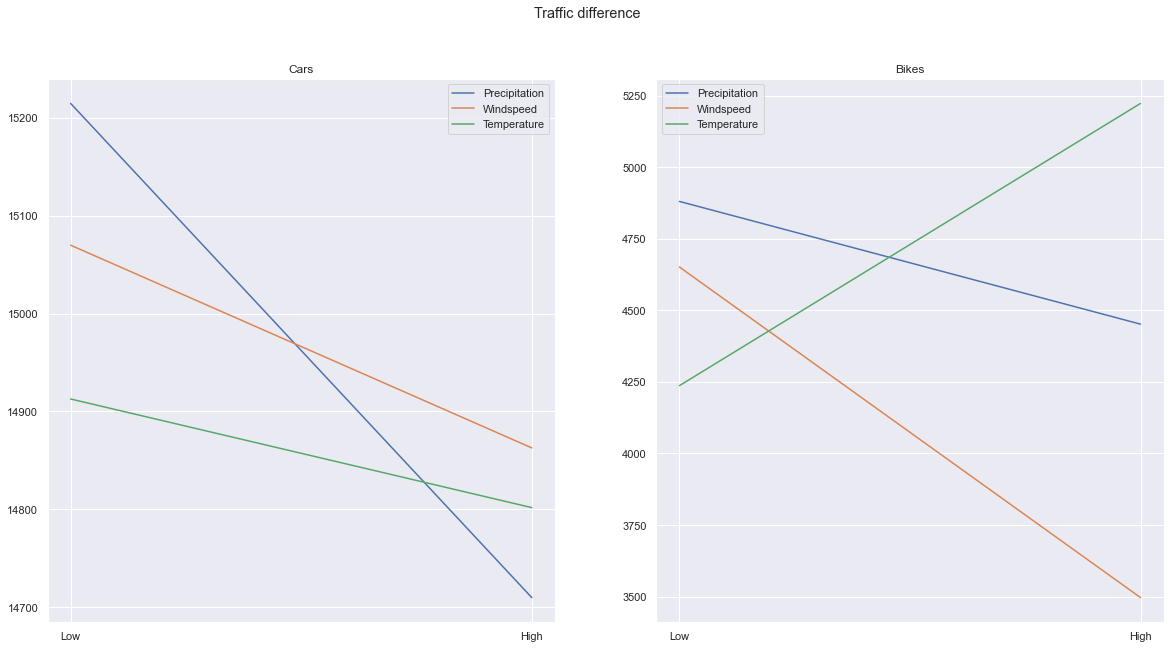

In [49]:
conditions = ['Precipitation', 'Windspeed', 'Temperature']

# Make the plot. We will do a slope plot.
fig, ax = plt.subplots(1, 2, figsize=(20,10))
# We are going to show the difference of the mean values
ax[0].plot([0, 1], [cars_low_precip.mean(), cars_high_precip.mean()])
ax[0].plot([0, 1], [cars_low_windspeed.mean(), cars_high_windspeed.mean()])
ax[0].plot([0, 1], [cars_low_temp.mean(), cars_high_temp.mean()])
ax[0].legend(conditions)
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Low', 'High'])
ax[0].set_title('Cars')
ax[1].plot([0, 1], [bike_low_precip.mean(), bike_high_precip.mean()])
ax[1].plot([0, 1], [bike_low_windspeed.mean(), bike_high_windspeed.mean()])
ax[1].plot([0, 1], [bike_low_temp.mean(), bike_high_temp.mean()])
ax[1].legend(conditions)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Low', 'High'])
ax[1].set_title('Bikes')
fig.suptitle('Traffic difference')
plt.show()

*__Figure Description:__* Slope plots that show the difference of the average daily traffic of cars and bicycles between high and low precipitation, windspeed and temperature.

***Result Comments:***: The figure shows that in our data, there are fewer cars when all the conditions are high. But remember that the only significant difference was in the precipitation. For the bikes however, there is less traffic when precipitation and windspeed are high, but more traffic when the temperature is high. 

### 4.4 Traffic predictions based on weather

We have made visualizations and set up a null hypothesis to see if we can interpret that weather conditions have an effect on the bike traffic in Copenhagen.  We have seen that it indeed has some effect on the car and bike traffic.
But the last thing we want to do was to try to predict the bike traffic for each of the stations.

***Summary:*** In the following section we will cover the machine learning model we chose to train and the performance of the model. We will also look into the feature importance and vizulize how a new data point is predicted.

*Tools:*
1. ``LabelEncoder``: Sklearn preprocessing package that is used to encode target labels with value between 0 and n_classes-1.
2. ``GridSearchCV``: Sklearn model selection package that makes exhaustive search over specified parameter values for an estimator.
3. ``RandomForestRegressor``: Machine learning model based on random forest estimators.
4. ``Shap``: Package that computes shapley values to explain complicated models.
5. ``dtreeviz``: A python library for decision tree visualization and model interpretation.

**Note:**
The code process will be explained in markdowns above each code cell and in code comments. Results will be commented below outputs if remarkable and figure descriptions are located below figures.

**Code Process 1/7:** 
The first thing we want to do is to get the data we want to use to train the model. The feature we use are location, month, day of week and weather features. 

In [50]:
#join the bike data and the weather data
bikes_weather = bicycle_data.merge(weather_data, left_on='Dato', right_on='date_')

In [51]:
#Get columns to use for the ML model
X = bikes_weather[['Vejnavn', 'month_x', 'day_of_week_x','temp','feelslike','precip','windspeed','winddir']]
y = bikes_weather['total']

**Code Process 2/7:** 
Next step is to encode the non-numerical features, here it is the vejnavn feature that is not numerical. We use the label encoder that gives each street name a integer value. 

In [52]:
#encode the 'vejnavn' column so it can be put in the model
le = preprocessing.LabelEncoder()
le.fit(X['Vejnavn'].unique())
X['Vejnavn_cl'] = le.transform(X['Vejnavn'])
#drop 'Vejnavn'
X.drop('Vejnavn', inplace=True, axis=1)
#print the integer for each street name
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Ellebjergvej': 0, 'Fredensbro': 1, 'Frederikssundsvej': 2, 'Hareskovvej': 3, 'Kalvebod Brygge': 4, 'Roskildevej': 5, 'Torvegade': 6, 'Vigerslev Allé': 7, 'Åboulevard': 8}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Result Comment** Above is the result of the encoding, each street name is represented by an integer. 

**Code Process 3/7:** 
Now we choose a model to train, this is a regression model and we decide to use a Random forest regressor, we know it is a good algorithm and we are familiar with it. The regressor takes a few parameters as input so to find the best parameters for our data we do a gridsearch after it has run we get the optimal parameters and use that to create and train our model on the train set. 

In [53]:
#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#do a grid search to find the best parameters
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(3,10),
        'n_estimators': (10, 100, 1000),
        'min_samples_split': [8, 10, 12],
        'min_samples_leaf': [3, 4, 5]
        },
cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)


grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_
    
#rfr = RandomForestRegressor(max_depth=5, n_estimators=10, min_samples_split = 8, min_samples_leaf =5,random_state=0, verbose=False)
rfr = RandomForestRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], min_samples_split = best_params['min_samples_split'] , min_samples_leaf = best_params['min_samples_leaf'],random_state=0, verbose=False)

In [54]:
print('Result of the grid search: ', best_params) 

Result of the grid search:  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}


**Result comments** Above are the best parameters that were observed by the gridsearch.

**Code Process 4/7:** 
When the model is ready we need to evaluate it, we want to compute the R^2 score and the error. 

In [55]:
#the r^2 score for both train and test and the best parameters
rfr.fit(X_train, y_train)
print('R^2 score for the train set: ', rfr.score(X_train, y_train))  
print('R^2 score for the test set: ', rfr.score(X_test, y_test))

R^2 score for the train set:  0.7089914098143162
R^2 score for the test set:  0.6625360315528706


In [56]:
# Evaluating the Algorithm
y_pred = rfr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1978.39051806309
Mean Squared Error: 9522641.278312247
Root Mean Squared Error: 3085.877716033519


**Result comments:** Above we can see the performance metrics we have computed. The R^2 is acceptable but we would want to have it a little bit higher. Also the error is pretty high. So our model is fine but could be better. To improve it we could try to gather data from more years or try to gather data from more stations. Also if we would have hourly weather dataset we could look more into the traffic on specific time, that might also be interesting. 

**Code Process 5/7:**  After we have trained the random forest regressor we are interested in looking into the feature importance of the model to get a clearer image of what features are important when predicting bike traffic. When training the model feature impartance have already been computed so we just need to plot them.

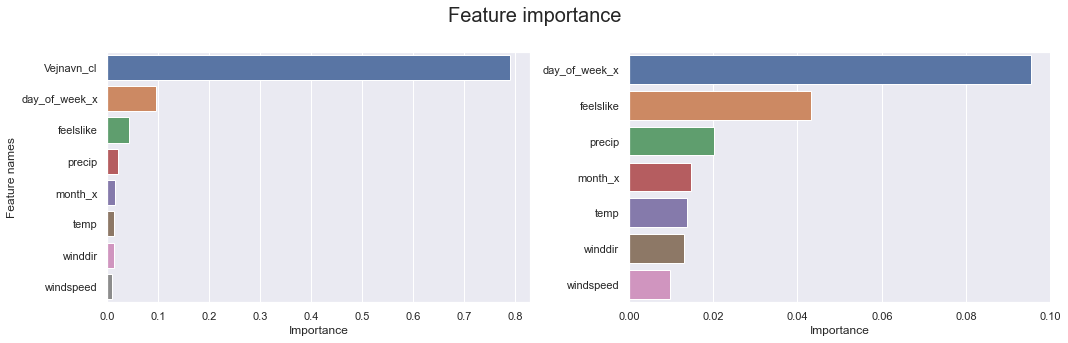

In [57]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#Create arrays from feature importance and feature names
feature_importance = np.array(rfr.feature_importances_)
feature_names = np.array(X.columns)

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=ax[0]).set(xlabel='Importance', ylabel=None)
#Add chart labels
ax[0].set_ylabel('Feature names')

feature_importance = np.array(rfr.feature_importances_)[:-1]
feature_names = np.array(X.columns)[:-1]

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=ax[1]).set(xlabel='Importance', ylabel=None)
#Add chart labels
fig.suptitle('Feature importance', size = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('feature_imp.png')
plt.show()

**Figure description:** Above we have a plot of the feature importance. To the left we have a plot of all the feature importances and to the right is a plot of all the feature importances except for the Vejnavn feature.

**Result comments:** In the plots we can see that the location is the most important feature, so location has the most effect on how many bikes pass by. That is not a surprise for us, since we saw that in the plot in section 4.1.2 that the traffic is very different between locations. There we also saw that bike traffic is less on the weekends, so it makes sense that it is the second most important feature. When looking at the weather feature feelslike is most important, from that we can interpret that depending on the tempature people feel has also some impact on if the decide to bike or not. 

**Code Process 6/7:**  We are interested in looking even further into feature importance and use a python package called shap. This package computes the shaply values of the model. Shapley values are a widely used approach from cooperative game theory that come with desirable properties.  

In [58]:
#fit the shap values
model = rfr.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

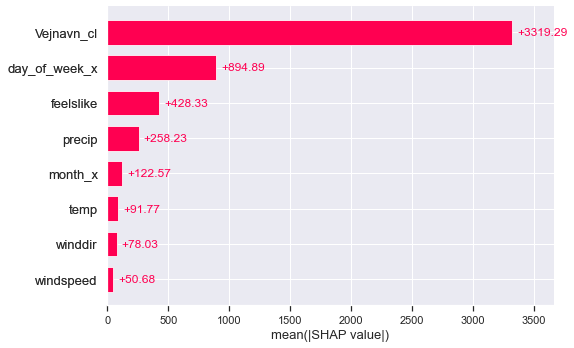

<Figure size 432x288 with 0 Axes>

In [59]:
#plot shap values
shap.plots.bar(shap_values)
plt.savefig('shapval.png')

**Figure description:** Above we have a plot of the shaply values.

**Result comments:** The shaply values give a little different result from the feature importance values. We can see that month has higher shaply value than tempature for example. Other result are similar, vejnavn has the highest shaply value and is thus the most important feature. Feelslike also has the highest shaply values for the weather features. 

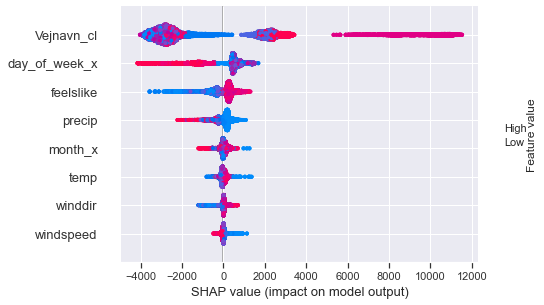

In [60]:
#summary plot of shap values
shap.summary_plot(shap_values, X)

**Figure description:** Above we have a summary plot of the shaply values.

**Result comments:** Here we have a different representation for the shaply values. Here we have different shaply values for different values of each feature. For example we can see that for higher percip we have lower shap value  which means that high percip lowers the number of bikes passing by. 

**Code Process 7/7:** Lastly we want to visualize how a new datapoint is predicted. Since our model is a random forest regressor and based on decision trees. We use a python package called dtreeviz. First we get a random sample for our data and we visualize how that point is precicted.

In [61]:
#Vizulize prediction of one descision tree 
sample = X.iloc[np.random.randint(0, len(X))] 
viz = dtreeviz(rfr.estimators_[0],
               X,
               y,
               target_name='total',
               feature_names=X.columns,
               X=sample,
               show_just_path=True)
              
viz

**Figure description:** Visualization of the branch that the datapoint goes trough when predicting its output.

**Result comments:** We can see that the datapoint is going through different decision boundaries of different features to predict its bike traffic. We can see that the prediction is made from the highlighted feature on this branch and it enters nine depths of the decision tree.

## 5. Genre

The website is set up in a magazine-style genre taking the reader on a visual and exploratory reading experience that introduces our findings and engages them with real-life facts on the topic. This allows us to introduce the problem, step by step leading the reader closer to a conclusion.


**Visual Narrative:** From the 3 categories discussed for the Visual Narrative we choose to go with the following visual narrative:

***Highlighting -> Zooming*** 

The zooming tool is both used in the interactive map of the measurement locations in Copenhagen which displays if the location measures car traffic, bike traffic, or both. The zoom functionality is also included in the Bokeh plots. In both cases, the functionality offers the user to explore the plots in more detail, for example, nearby street names and landmarks on the map, and obtain closer comparison measurements. This way the user experiences the freedom to explore independently which might give a different angle to the reading experience.

**Narrative Structure:** From the 3 categories discussed for the Narrative Structure we choose to go with the following narrative structure:

***Interactivity: , Filtering/Selection, Hover - Highlighting/Details***
The Folium map of measurement locations and the interactive Bokeh plots enable the user to filter and highlight specific aspects of the visualization that output the user's selection. This way the user experiences the freedom to explore independently which might give a different angle to the reading experience.

***Messaging: Captions/Headlines, Introductory Text and Summary***

The website uses headlines and captions to sectionize the article into interesting chunks to make the article more engaging. Each section is structured with an introduction, visualization, and summary to make the different aspects enjoyable. We believe that this grouping within the article makes it accessible and easily read.[[2]](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)


## 6. Visualizations

The project holds multiple kinds of plots to support the storyline of the project. The following section will discuss the decisions made for each chapter of the notebook.

### Basic Stats
#### 3.2.5 Basic Stats - Weather Data

To give the user an overview of precipitation in the Copenhagen area for the years 2012, 2013, and 1014 we use a barplot comparing the average number of rainy and dry days per month. To dig even deeper into the weather overview a calendar-based heatmap for different weather conditions was used. This provides a yearly overview of how different weather conditions are distributed over each year of the data. 


#### 3.2.6: Basic Stats - Traffic Data
To visualize the traffic count distribution per year we used boxplots to indicate the bike and car traffic data properties along with their statistical facts. Finally, the traffic distribution for cars and bikes was visualized in a histogram to show the frequency of measurement sizes. In this way, we manage to both provide statistical facts about our data and show the distribution of values.

### Data Analysis

#### 4.1 Measurement locations and geopatterns
#### 4.1.1 Measurement Locations
In this section, we wanted to give our readers an idea of where the traffic measurement locations were located and if they measured bike traffic, car traffic, or both. It was ideal to use the geographical properties of the dataset to visualize this using the Folium library to generate a map indicating each measurement location and the type of measurements they make.

#### 4.1.2 Traffic distribution per measurement locations
To visualize the temporal traffic patterns on a weekly and monthly level across all measurement locations we used bar plots. This was the obvious way to go for this data analysis since bar plots are effective when comparing different groups or tracking changes over time.

#### 4.2 Temporal Traffic Patterns and Weather Affects
#### 4.2.1  Temporal Traffic Patterns & 4.2.2 Temporal Traffic Patterns and Weather Affects
To analyze and compare temporal traffic patterns and how they are affected by different weather conditions we used stacked bar plots. This allows the user to follow the temporal patterns bt at the same time compare the bike and car traffic at each time. These plots were implemented using Bokeh to make them interactive and allow independent exploration for the end-user.

#### 4.3 Is there a correlation between specific weather conditions and commute behavior?
To visualize the difference in commute behavior based on weather conditions we used a slope chart. This allows us to analyze the mean across the different weather conditions.

#### 4.4 Traffic predictions based on weather
To support the conclusion from our machine learning model we visualized the feature's importance using bar plots. Barplots are great for comparison so that was an obvious choice for the feature importance comparison. Digging deeper into the feature importance we used visualization of shap values that visualize how the value of the input features affects the output. Finally to engage the user in how the model predicts we visualized one path from the decision try and explained the reason for the exact choices.




Overall the choices made regarding visualizations were organized to introduce various kinds of plots and keep the reader engaged. Each visualization has a clear goal regarding engagement and opportunities for the reader to understand different aspects of the data easily.

## 6. Discussion

The goal of this project was threefold.

1. Look into how and if weather affects bike and car traffic in Copenhagen.
2. Look into if the traffic transitions in between cars and bikes for different weather conditions.
3. Predict bike traffic based on weather data.

The result could be used to interpret if Copenhagen is as green as considered regarding transportation and if there is room for changes in commute behavior.

The first two aspects were successful and we managed to create some great visualizations to support our results and comment on. The reader is also provided with an extended data overview and basic stats before entering the analysis aspect of the project. Having investigated the data, we managed to show that the weather does indeed affect their willingness to commute by bicycle. There are significantly fewer bikes on the cycle tracks if it is raining, the wind is high or the temperature is low. On the contrary, it seems like people do not let the weather affect their usage of cars, except for when it rains when there are actually fewer cars on the street. One might think that lower wind speed and higher temperature would encourage people to keep the car at home, but our data shows that isn't the case. It looks like people just like staying at home when it rains instead of going to work or school. Or maybe they just use other modes of transport. To find the reason, we would have to dig deeper, gather more data, and continue our analysis.

The third part could have been more accurate but the result is as good as they can be with the data used. Increasing traffic data and providing hourly weather data for the entire period would advance the model enormously since it would be able to pick up on patterns more easily. Based on our result from the model the most influential weather feature is the feelslike attribute, it would be interesting to see if hourly weather data would affect that conclusion.


Overall the project tells a story and uses direct visualizations to support results, enabling the reader to connect with the data and question the results obtained by the authors.

## 7. Contributions. 

**Assignment Contributions**:

* Halla María (s212958) took the lead in data gathering and preprocessing, basic stats of weather data, interactive bokeh plots, and formatting and markdown implementation in the explainers notebook.
* Sigríður Þóra (s212945) took the lead in machine learning model implementation, website implementation, basic stats of traffic data, and temporal patterns.
* Þórður Örn (s212957) took the lead in the map creation, t-test and slope chart implementation, and website implementation.

All team members participated in the implementation of each part, taking the lead means being responsible for the part and starting the core implementation. Website and explainer notebook work was a collaboration of all tea,m members where Halla beared the responsibility for the notebook and Þórður and Sigga took the lead in the website creation/implementation.



## 8. References

[1] - https://sustainabilitymag.com/top10/top-10-most-sustainable-cities-world

[2] - http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf